## Zadanie projektowe nr 1
##### Algorytmy genetyczne i roje cząstek
---
##### Wybrany problem to "Rozwiązywanie Fill-a-pixów"
##### Zasady:
Mamy planszę, na której musimy zamalować kratki na czarno, tak aby utworzyły obrazek.
Niektóre kratki mają wewnątrz liczbę, która informuje, ile kratek na czarno powinno być w
sąsiedztwie.
Maksimum sąsiadów to 9:
* 8 dookoła kratki
* 1 to sama kratka
* minimum to 0

Niektóre pola mogą być puste – nie informują o liczbie czarnych
kratek w sąsiedztwie, mimo że mogą je mieć.

##### Rzeczy które musimy zaimportować

In [2]:
# do używania algorytmu genetycznego
import pygad

# do wyświetlania obrazków
import matplotlib.pylab as plt

# do wczytywania obrazków
import matplotlib.image as mpimg

# do tworzenia animacji
import matplotlib.animation as animation

# do liczenia pierwiastka
from math import sqrt

# do mierzenia czasu
import time

# do używania Roju
import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history
import numpy as np

##### Najpierw obrazki, do których nasze algorytmy będą próbowały znaleźć.

Text(0.5, 1.0, 'image 20x20')

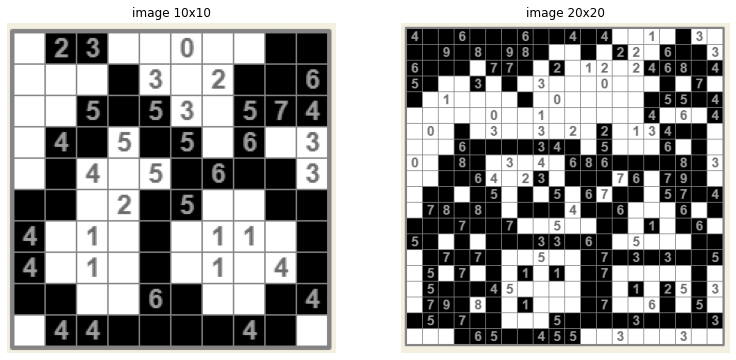

In [4]:
# pobierania obrazków
fill_a_pix_10_x_10_image = mpimg.imread('./fillAPix10x10.PNG')
fill_a_pix_20_x_20_image = mpimg.imread('./fillAPix20x20.PNG')

# tworzymy pojemnik w którym będą obrazki
fig = plt.figure(figsize=(20, 20))

# 3 obrazki w 1 rzędzie
rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(fill_a_pix_10_x_10_image)
plt.axis('off')
plt.title("image 10x10")

fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(fill_a_pix_20_x_20_image)
plt.axis('off')
plt.title("image 20x20")

* Teraz te obrazki potrzebujemy w formie, którą zrozumie nasz program.
* Zamienimy je na listę list, a "-1" będzie oznaczało brak liczby na polu.
* Dodamy też zmienne do przechowywania kolejnych etapów poszukiwania rozwiązania, by móc zrobić z tego animacje.

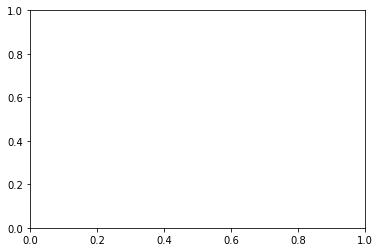

In [5]:
# obrazek 10x10 na tablice tablic
fill_a_pix_10_x_10 = [[-1, 2, 3, -1, -1, 0, -1, -1, -1, -1],
                        [-1, 2, -1, -1, 3, -1, 2, -1, -1, 6],
                        [-1, -1, 5, -1, 5, 3, -1, 5, 7, 4],
                        [-1, 4, -1, 5, -1, 5, -1, 6, -1, 3],
                        [-1, -1, 4, -1, 5, -1, 6, -1, -1, 3],
                        [-1, -1, -1, 2, -1, 5, -1, -1, -1, -1],
                        [4, -1, 1, -1, -1, -1, 1, 1, -1, -1],
                        [4, -1, 1, -1, -1, -1, 1, -1, 4, -1],
                        [-1, -1, -1, -1, 6, -1, -1, -1, -1, 4],
                        [-1, 4, 4, -1, -1, -1, -1, 4, -1, -1]]

# rozwiązanie do obrazka 10x10
fill_a_pix_10_x_10_solution = [[0, 1, 1, 0, 0, 0, 0, 0, 1, 1],
                            [0, 0, 0, 1, 0, 0, 0, 1, 1, 1],
                            [0, 0, 1, 1, 1, 0, 0, 1, 1, 1],
                            [0, 1, 1, 0, 1, 1, 0, 1, 0, 0],
                            [0, 1, 0, 0, 0, 1, 1, 1, 1, 0],
                            [1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
                            [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
                            [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
                            [1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
                            [0, 1, 1, 1, 1, 1, 1, 1, 1, 0]]

# obrazek 20x20 na tablice tablic
fill_a_pix_20_x_20 = [[4, -1, -1, 6, -1, -1, -1, 6, -1, -1, 4, -1, 4, -1, -1, 1, -1, -1, 3, -1],
                    [-1, -1, 9, -1, 8, -1, 9, 8, -1, -1, -1, -1, -1, 2, 2, -1, 6, -1, -1, 3],
                    [6, -1, -1, -1, -1, 7, 7, -1, -1, 2, -1, 1, 2, -1, 2, 4, 6, 8, -1, 4],
                    [5, -1, -1, -1, 3, -1, -1, -1, 3, -1, -1, -1, 0, -1, -1, -1, -1, -1, 7, -1],
                    [-1, -1, 1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, 5, 5, -1, 4],
                    [-1, -1, -1, -1, -1, 0, -1, -1, 1, -1, -1, -1, -1, -1, -1, 4, -1, 6, -1, 4],
                    [-1, 0, -1, -1, -1, 3, -1, -1, 3, -1, 2, -1, 2, -1, 1, 3, 4, -1, -1, -1],
                    [-1, -1, -1, 6, -1, -1, -1, -1, 3, 4, -1, -1, 5, -1, -1, -1, 6, -1, -1, -1],
                    [0, -1, -1, 8, -1, -1, 3, -1, 4, -1, 6, 8, 6, -1, -1, -1, -1, 8, -1, 3],
                    [-1, -1, -1, -1, 6, 4, -1, 2, 3, -1, -1, -1, -1, 7, 6, -1, 7, 9, -1, -1],
                    [-1, -1, -1, -1, -1, 5, -1, -1, -1, 5, -1, 6, 7, -1, -1, -1, 5, 7, -1, 4],
                    [-1, 7, 8, -1, 8, -1, -1, -1, -1, -1, 4, -1, -1, 6, -1, -1, -1, 6, -1, -1],
                    [-1, -1, -1, 7, -1, -1, 7, -1, -1, 5, -1, -1, -1, -1, -1, 1, -1, -1, 6, -1],
                    [5, -1, -1, -1, -1, -1, -1, -1, 3, 3, -1, 6, -1, -1, 5, -1, -1, -1, -1, -1],
                    [-1, -1, 7, -1, 7, -1, -1, -1, 5, -1, -1, -1, 7, -1, 3, -1, 3, -1, -1, 5],
                    [-1, 5, -1, 7, -1, -1, -1, 1, -1, 1, -1, -1, 7, -1, -1, -1, -1, -1, -1, -1],
                    [-1, 5, -1, -1, -1, 4, 5, -1, -1, -1, -1, -1, -1, -1, 1, -1, 2, 5, -1, 3],
                    [-1, 7, 9, -1, 8, -1, -1, 1, -1, -1, -1, -1, 7, -1, -1, 6, -1, -1, 5, -1],
                    [-1, 5, -1, 7, -1, -1, -1, -1, -1, 5, -1, -1, -1, -1, 3, -1, -1, -1, -1, 3],
                    [-1, -1, -1, -1, 6, 5, -1, -1, 4, 5, 5, -1, -1, 3, -1, -1, -1, 3, -1, -1]]

# rozwiązanie do obrazka 20x20
fill_a_pix_20_x_20_solution = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0],
                            [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
                            [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
                            [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
                            [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
                            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
                            [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
                            [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                            [0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
                            [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1],
                            [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1],
                            [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0],
                            [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1],
                            [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                            [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
                            [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0],
                            [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0],
                            [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                            [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


# zmienne potrzebne, do stworzenia animacji
fill_a_pix_10_x_10_images = []
fill_a_pix_20_x_20_images = []
fig, ax = plt.subplots()

### Najpierw Algorytm genetyczny oraz fill-a-pix 10x10
---

### Pierwsza funkcja fitness.

##### Pomysł na funkcje:
1. Znajdujemy bloczek z liczbą inną niż "-1".
2. Liczymy ile jest czarnych bloczków
3. Patrzymy o ile się różni ta liczba od tego ile być powinno
4. otrzymany wynik zmieniamy na ujemną liczbę i tą są punkty karne.
5. Dążymy do tego, by punktów karnych nie było, czyli dążymy do zera.
---
Funkcja fitness przyjmuje jako argument "solution", czyli listę 100 zer i jedynek.
Trzeba ją zmienić na listę list 10x10, żeby móc ją porównać z naszym fillAPix10x10.
Do tego wykorzystamy funkcję "change_to_list_of_lists"


In [6]:
def change_to_list_of_lists(local_list, length):
    # length = jakiej długości mają być listy wewnętrzne
    # ostateczny wynik
    list_of_lists = []

    # pojedynczy rząd, bo do ostatecznego wyniku będziemy dodawać rzędy (listy)
    list_of_lists_row = []

    # index, na którym jesteśmy w liście którą zmieniamy
    list_index = 0

    for i1 in range(length):
        for i2 in range(length):
            # Zaokrąglanie jest potrzebne przy pso global
            # pso global generuje liczby zmienno przecinkowe z zakresu [0,1],
            # więc musimy je zaokrąglić do zer i jedynek
            rounded_number = round(local_list[list_index])

            # tworzymy jeden rząd
            list_of_lists_row.append(rounded_number)
            list_index += 1

        # dodajemy rząd i go resetujemy
        list_of_lists.append(list_of_lists_row)
        list_of_lists_row = []

    return list_of_lists

### Blok, w którym ustawiamy naszą funkcje fitness (fill-a-pix 10x10) (funkcja 1)

In [7]:
def fitness_func10x10(solution, solution_idx):
    # solution jest wypełniony zerami i jedynkami
    # zero = białe pole, jedynka = czarne pole

    # liczymy punkty karne, idealnie = brak punktów karnych
    penalty_points = 0

    # długość jednego rzędu
    length = int(sqrt(len(solution)))

    # najpierw zmieniamy listę długości 100 na listę 10x10
    solution_10_x_10 = change_to_list_of_lists(solution, length)

    for i1 in range(length):
        for i2 in range(length):
            if fill_a_pix_10_x_10[i1][i2] != -1:
                # sprawdzamy ile jest czarnych pól
                # przy sumowanie wystarczy sumować wartości pól, bo czarne pole to 1, a białe to 0

                # odpowiednia liczba czarnych kratek to wartość pola obrazka w formie tablicy tablic
                correct_number_of_black_blocks = fill_a_pix_10_x_10[i1][i2]

                # na starcie do sumy dodajemy wartość pola, które analizujemy i ilość czarnych pól dookoła
                number_of_black_blocks = solution_10_x_10[i1][i2] + get_number_of_black_pixels_around_this_pixel(i1, i2, solution_10_x_10, length)

                # o ile od prawidłowej liczby czarnych kratek różniła się uzyskana liczba
                penalty_points -= abs(correct_number_of_black_blocks - number_of_black_blocks)


    # zbieramy obrazki każdego etapu by zrobić z nich animacje
    # im = ax.imshow(solution_10_x_10, animated=True)
    # fill_a_pix_10_x_10_images.append([im])

    # karne punkty są ujemne, bo dla obecnego algorytmu im wyższa liczba, tym lepsza
    return penalty_points

#### Funkcja licząca ile jest czarnych kratek do około kratki, którą analizujemy.

In [8]:
def get_number_of_black_pixels_around_this_pixel(i1, i2, list_of_lists, length):
    number_of_black_blocks = 0
    # zanim sprawdzimy wartość kratki, trzeba sprawdzić, czy ta kratka nie wychodzi poza liste,
    # jeżeli wychodzi poza liste, zwracamy 0, które w dodawaniu nic nie zmienia

    # sprawdzamy kratkę po prawej stronie
    number_of_black_blocks += list_of_lists[i1][i2 + 1] if (i2 + 1) < length else 0

    # sprawdzamy kratkę po lewej stronie
    number_of_black_blocks += list_of_lists[i1][i2 - 1] if (i2 - 1) >= 0 else 0

    # sprawdzamy kratki na górze
    number_of_black_blocks += list_of_lists[i1 - 1][i2] if (i1 - 1) >= 0 else 0
    number_of_black_blocks += list_of_lists[i1 - 1][i2 + 1] if (i1 - 1) >= 0 and (i2 + 1) < length else 0
    number_of_black_blocks += list_of_lists[i1 - 1][i2 - 1] if (i1 - 1) >= 0 and (i2 - 1) >= 0 else 0

    # sprawdzamy kratki na dole
    number_of_black_blocks += list_of_lists[i1 + 1][i2] if i1 + 1 < length else 0
    number_of_black_blocks += list_of_lists[i1 + 1][i2 + 1] if (i1 + 1) < length and (i2 + 1) < length else 0
    number_of_black_blocks += list_of_lists[i1 + 1][i2 - 1] if (i1 + 1) < length and (i2 - 1) >= 0 else 0

    return number_of_black_blocks

### Blok gdzie konfigurujemy algorytm. (fill-a-pix 10x10) (funkcja 1)

In [9]:
# zakres wartość pojawiających się w solution tylko zera i jedynki
gene_space = [0, 1]

# gdy wynik jest większy równy zero kończymy, bo jest to brak punktów karnych i osiągnęliśmy najlepszy możliwy wynik
stop_crit = ["reach_0"]

# funkcja fitness
fitness_function = fitness_func10x10

# ile chromosomów w populacji
sol_per_pop = 30 #30

# ile genów ma chromosom
num_genes = 100 #100

# ile wyłaniamy rodziców do "rozmnażania"
num_parents_mating = 8 #15

# ile pokoleń
num_generations = 190 # 150

# ilu rodziców zachować (kilka procent)
keep_parents = 4 # 5

# jaki typ selekcji rodziców?
# sss = steady, rws=roulette, rank = rankingowa, tournament = turniejowa
parent_selection_type = "sss"

# w ilu punktach robić krzyżowanie?
# "single_point" = skrzyżowanie robimy w jednym punkcie
crossover_type = "two_points" # single_point

# na ilu procent genów ma działać mutacja?
mutation_percent_genes = 1 #2

# typ mutacji
mutation_type = "random"

### uruchomienie algorytmu. (fill-a-pix 10x10) (funkcja 1)

In [10]:
# czyścimy z poprzednich obrazków do animacji
fill_a_pix_10_x_10_images = []

# do liczenia średniej czasu
average_time = 0

# zbieramy sumę do liczenia średniej punktów karnych
results = 0

# zbieramy sumę do liczenia średniej realnej ilości źle wypełnionych kratek
real_result = 0

# do testów można wybrać ile razy uruchomimy algorytm
for a in range(10):
    # zaczynamy liczyć czas
    start = time.time()

    # ustawienie algorytmu
    ga_instance = pygad.GA(gene_space=gene_space,
                           num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_function,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes,
                           parent_selection_type=parent_selection_type,
                           keep_parents=keep_parents,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_percent_genes,
                           stop_criteria=stop_crit,
                           )

    # uruchomienie algorytmu
    ga_instance.run()

    # podsumowanie: najlepsze znalezione rozwiązanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

    # wyświetlenie wykresu: jak się zmieniała wartość punktów karnych na kolejnych etapach
    # ga_instance.plot_fitness()

    # liczymy ile czasu działał algorytm i dodajemy, by policzyć średnią
    end = time.time()
    average_time += (end - start)

    # do zrobienia obrazka i policzenia realnie źle wypełnionych kratek potrzebujemy listę list 10x10
    # dlatego na rozwiązaniu, które dał nam algorytm używamy naszej funkcji
    solution_10_x_10 = change_to_list_of_lists(solution, 10)

    # # zrobienie obrazka z finalnego rozwiązania
    # mask = np.array(solution_10_x_10, dtype=bool)

    # # wyświetlenie tego obrazka
    # plt.imshow(mask, cmap='gray')
    # plt.show()

    number_of_wrong_pixels = 0
    # policzenie realnej ilość blednie uzupełnionych pexeli porównując z rozwiązaniem
    for i1 in range (10):
        for i2 in range (10):
            if fill_a_pix_10_x_10_solution[i1][i2] != solution_10_x_10[i1][i2]:
                number_of_wrong_pixels += 1

    real_result += number_of_wrong_pixels
    results += solution_fitness

    print("Real number of wrong pixels = {number_of_wrong_pixels}".format(number_of_wrong_pixels=number_of_wrong_pixels))


# # stworzenie i zapisanie animacji
# ani = animation.ArtistAnimation(fig, fill_a_pix_10_x_10_images, interval=50000, blit=True,
#                                 repeat_delay=1000)
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

print("średnia karnych punktów: ", results/10)
print("średnia realnie źle wypełnionych bloczków: ", real_result/10)
print("średni czas: ", average_time/10)

Fitness value of the best solution = -6
Real number of wrong pixels = 27
Fitness value of the best solution = -4
Real number of wrong pixels = 15
Fitness value of the best solution = -6
Real number of wrong pixels = 27
Fitness value of the best solution = -7
Real number of wrong pixels = 32
Fitness value of the best solution = -4
Real number of wrong pixels = 26
Fitness value of the best solution = -5
Real number of wrong pixels = 31
Fitness value of the best solution = -4
Real number of wrong pixels = 16
Fitness value of the best solution = -5
Real number of wrong pixels = 14
Fitness value of the best solution = -4
Real number of wrong pixels = 23
Fitness value of the best solution = -3
Real number of wrong pixels = 16
średnia karnych punktów:  -4.8
średnia realnie źle wypełnionych bloczków:  22.7
średni czas:  1.8101696014404296


#### Testowanie obrazka 10x10
##### Podstawowe Ustawienia:

* sol_per_pop = 30
* num_genes = 100
* num_parents_mating = 15
* num_generations = 150
* keep_parents = 5
* parent_selection_type = "sss"
* crossover_type = "single_point"
* mutation_percent_genes = 2
* mutation_type = "random"
---

#### testy robione na 10 próbach
##### Obecne ustawienia:
średni wynik punktów karnych: -7.3
średni wynik realnie źle wypełnionych bloczków: 24.5

##### Zmiana 1
"mutation_percent_genes" na liczby 6, 8, 1
* 6 - średnia karnych punktów: -16.5
* 6 - średni wynik realnie źle wypełnionych bloczków: 30.55
*
* 8 - średnia karnych punktów: -18.3
* 8 - średni wynik realnie źle wypełnionych bloczków: 30.6
*
* 1 - średnia karnych punktów: -5.5
* 1 - średni wynik realnie źle wypełnionych bloczków: 23.7

Wzrost procentu mutowanych genów znacznie pogarsza wyniki.
Natomiast zmniejszenie poprawiło wyniki.

##### Zmiana 2
num_parents_mating = 10, 8, 5
* 10 - średnia karnych punktów: -5.7
* 10 - średni wynik realnie źle wypełnionych bloczków: 20.5
*
* 8 - średnia karnych punktów: -5.5
* 8 - średni wynik realnie źle wypełnionych bloczków: 21.5
*
* 5 - średnia karnych punktów: -5.9
* 5 - średni wynik realnie źle wypełnionych bloczków: 22.9

Gdy wykorzystujemy mniejszą liczbę rodziców, wynik się poprawia, choć nie można przesadzić.

##### Zmiana 3
num_parents_mating = 8
keep_parents = 4
mutation_percent_genes = 1
* średnia karnych punktów:  -5.5
* średnia realnie źle wypełnionych bloczków: 21.1
Najlepszy wynik:
* ilość karnych punktów: -3.0
* ilość realnie źle wypełnionych bloczków: 14
Zmniejszenie liczby zatrzymywanych rodziców niekoniecznie poprawiło średnią, ale osiągnąłem do tej pory najlepszy wynik.

##### Zmiana 4
num_parents_mating = 8
keep_parents = 4
mutation_percent_genes = 1
num_generations = 190
* średnia karnych punktów: -4.8
* średnia realnie źle wypełnionych bloczków: 18.9
Najlepszy wynik:
* ilość karnych punktów: -1.0
* ilość realnie źle wypełnionych bloczków: 12
Zwiększenie liczby generacji poprawiło średnią i udało się osiągnąć bardzo dobry najlepszy wynik.


##### Zmiana 5
Ustawienia ze zmiany 4
mutation_type = "swap"
* średnia karnych punktów:  -24.4
* średnia realnie źle wypełnionych bloczków: 37.3
Niestety typ mutacji "swap" nie jest tu dobrym wyborem, wynik się znacznie pogorszył.

Swap -
Stosuje mutację swap, która zamienia wartości 2 losowo wybranych genów.

##### Zmiana 6
Ustawienia ze zmiany 4
crossover_type = "two_points"
* średnia karnych punktów: -4.6
* średnia realnie źle wypełnionych bloczków: 22.0
Zwiększenie ilości punktów przy mutacji lekko polepszyło średnią karnych punktów.

Two_points -
Wybiera losowo 2 punkty, w których zachodzi krzyżowanie między parami rodziców.


### Teraz Fill-a-Pix 20x20 (funkcja 1)
Dla czytelności zmiennych będzie to winnych blokach kodu.

### Blok, w którym ustawiamy naszą funkcję fitness
Używamy tej samej funkcji fitness.
Teraz dopasujemy nazwy zmiennych do fill-a-pix 20x20.

In [7]:
def fitness_func20x20(solution, solution_idx):
    # solution jest wypełniony zerami i jedynkami
    # zero = białe pole, jedynka = czarne pole

    # liczymy punkty karne, idealnie = brak punktów karnych
    penalty_points = 0

    # długość jednego rzędu
    length = int(sqrt(len(solution)))

    # najpierw zmieniamy listę długości 400 na listę 20x20
    solution_20_x_20 = change_to_list_of_lists(solution, length)

    for i1 in range(length):
        for i2 in range(length):
            if fill_a_pix_20_x_20[i1][i2] != -1:
                # sprawdzamy ile jest czarnych pól
                # przy sumowanie wystarczy sumować wartości pól, bo czarne pole to 1, a białe to 0

                # odpowiednia liczba czarnych kratek to wartość pola obrazka w formie tablicy tablic
                correct_number_of_black_blocks = fill_a_pix_20_x_20[i1][i2]

                # na starcie do sumy dodajemy wartość pola, które analizujemy i ilość czarnych pól dookoła
                number_of_black_blocks = solution_20_x_20[i1][i2] + get_number_of_black_pixels_around_this_pixel(i1, i2, solution_20_x_20, length)

                # o ile od prawidłowej liczby czarnych kratek różniła się uzyskana liczba
                penalty_points -= abs(correct_number_of_black_blocks - number_of_black_blocks)


    # zbieramy obrazki każdego etapu by zrobić z nich animacje
    im = ax.imshow(solution_20_x_20, animated=True)
    fill_a_pix_20_x_20_images.append([im])

    # karne punkty są ujemne, bo im zwracana liczba jest wyższa, tym lepiej
    return penalty_points

### Blok gdzie konfigurujemy algorytm. (Fill-a-Pix 20x20) (funkcja 1)

In [8]:
# zakres wartość pojawiających się w solution tylko zera i jedynki
gene_space = [0, 1]

# gdy wynik jest większy równy zero kończymy, bo jest to brak punktów karnych i osiągnęliśmy najlepszy możliwy wynik
stop_crit = ["reach_0"]

# funkcja fitness
fitness_function = fitness_func20x20

# ile chromosomów w populacji
sol_per_pop = 30 #30

# ile genów ma chromosom 20x20, czyli trzeba ich 400
num_genes = 400

# ile wyłaniamy rodziców do "rozmnażania"
num_parents_mating = 8 #15

# ile pokoleń
num_generations = 190 # 150

# ilu rodziców zachować (kilka procent)
keep_parents = 4 #5

# jaki typ selekcji rodziców?
# sss = steady, rws=roulette, rank = rankingowa, tournament = turniejowa
parent_selection_type = "sss"

# w ilu punktach robić krzyżowanie?
# "single_point" = skrzyżowanie robimy w jednym punkcie
crossover_type = "two_points"

# na ilu procentach genów ma działać mutacja?
mutation_percent_genes = 1 #1

# typ mutacji
mutation_type = "random"

In [12]:
# do liczenia średniej czasu
average_time = 0

# czyścimy z poprzednich obrazków do animacji
fill_a_pix_20_x_20_images = []

# zbieramy sumę do liczenia średniej punktów karnych
results = 0

# zbieramy sumę do liczenia średniej realnej ilości źle wypełnionych bloczków
real_result = 0

# do testów można wybrać ile razy uruchomimy algorytm
for a in range(1):
    # zaczynamy liczyć czas
    start = time.time()

    # ustawienie algorytmu
    ga_instance = pygad.GA(gene_space=gene_space,
                           num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_function,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes,
                           parent_selection_type=parent_selection_type,
                           keep_parents=keep_parents,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_percent_genes,
                           stop_criteria=stop_crit,
                           )

    # uruchomienie algorytmu
    ga_instance.run()

    #podsumowanie: najlepsze znalezione rozwiązanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

    # wyświetlenie wykresu: jak się zmieniała wartość karnych punktów na kolejnych etapach
    # ga_instance.plot_fitness()

    # liczymy ile czasu działał algorytm i dodajemy, by policzyć średnią
    end = time.time()
    average_time += (end - start)

    # do zrobienia obrazka i policzenia realnie źle wypełnionych kratek potrzebujemy listę list 10x10
    # dlatego na rozwiązaniu, które dał nam algorytm używamy naszej funkcji
    solution_20_x_20 = change_to_list_of_lists(solution, 20)

    # zrobienie obrazka z finalnego rozwiązania
    # mask = np.array(solution_20_x_20, dtype=bool)
    # # wyświetlenie tego obrazka
    # plt.imshow(mask, cmap='gray')
    # plt.show()

    number_of_wrong_pixels = 0
    # policzenie realnej ilość błędnie uzupełnionych pexeli porównując z rozwiązaniem
    for i1 in range (20):
        for i2 in range (20):
            if fill_a_pix_20_x_20_solution[i1][i2] != solution_20_x_20[i1][i2]:
                number_of_wrong_pixels += 1

    real_result += number_of_wrong_pixels
    results += solution_fitness

    print("Real number of wrong pixels = {number_of_wrong_pixels}".format(number_of_wrong_pixels=number_of_wrong_pixels))

# # stworzenie i zapisanie animacji
# ani = animation.ArtistAnimation(fig, fill_a_pix_20_x_20_images, interval=100, blit=True,
#                                 repeat_delay=1000)
#
# ani.save("movie1.mp4")

# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie1.mp4", writer=writer)

print("średnia karnych punktów: ", results/10)
print("średnia realnie źle wypełnionych bloczków: ", real_result/10)
print("średni czas: ", average_time/10)

Fitness value of the best solution = -42
Real number of wrong pixels = 97
średnia karnych punktów:  -4.2
średnia realnie źle wypełnionych bloczków:  9.7
średni czas:  0.5893739223480224


#### Testowanie obrazka 20x20
##### Podstawowe Ustawienia:

* sol_per_pop = 30
* num_genes = 400
* num_parents_mating = 15
* num_generations = 150
* keep_parents = 5
* parent_selection_type = "sss"
* crossover_type = "single_point"
* mutation_percent_genes = 2
* mutation_type = "random"
---

#### testy robione na 10 próbach
##### Obecne ustawienia:
średnia karnych punktów: -88.7
średnia realnie źle wypełnionych bloczków: 128.6

##### Zmiana 1
"mutation_percent_genes" na wyższe liczby 6, 8, 1
* 6 - średnia karnych punktów: -134.5
* 6 - średni wynik realnie źle wypełnionych bloczków: 142.5
*
* 8 - średnia karnych punktów: -143.7
* 8 - średni wynik realnie źle wypełnionych bloczków: 142.6
*
* 1 - średnia karnych punktów: -64.4
* 1 - średni wynik realnie źle wypełnionych bloczków: 112.9

Wzrost procentu mutowanych genów pogarsza wyniki, bez zmian.

##### Zmiana 2
num_parents_mating = 10, 8, 5
* 10 - średnia karnych punktów: -85.0
* 10 - średni wynik realnie źle wypełnionych bloczków: 126.0
*
* 8 - średnia karnych punktów: -78.5
* 8 - średni wynik realnie źle wypełnionych bloczków: 117.9
*
* 5 - średnia karnych punktów: -79.5
* 5 - średni wynik realnie źle wypełnionych bloczków: 126.0

Gdy wykorzystujemy mniejszą liczbę rodziców, wynik się poprawia to bez zmian i też nie można przesadzić.

##### Zmiana 3
num_parents_mating = 8
keep_parents = 4
mutation_percent_genes = 1
* średnia karnych punktów:  -81.4
* średnia realnie źle wypełnionych bloczków: 122.9
Najlepszy wynik do tej pory:
* ilość karnych punktów = -72.0
* ilość realnie źle wypełnionych bloczków = 123

Zmniejszenie liczby zatrzymywanych rodziców niekoniecznie poprawiło średnią, ale osiągnąłem do tej pory najlepszy wynik.
Bez zmian.

##### Zmiana 4
num_parents_mating = 8
keep_parents = 4
mutation_percent_genes = 1
num_generations = 190
* średnia karnych punktów: -54.3
* średnia realnie źle wypełnionych bloczków: 107.6
najlepszy wynik:
* ilość karnych punktów = -48.0
* ilość realnie źle wypełnionych bloczków = 94
Zwiększenie liczby generacji bardziej poprawiło średnią niż ostatnio i najlepszy wynik też się poprawił.

##### Zmiana 5
Ustawienia ze zmiany 4
mutation_type = "swap"
* średnia karnych punktów:  -118.6
* średnia realnie źle wypełnionych bloczków: 144.4

Niestety typ mutacji "swap" nie jest tu dobrym wyborem, wynik się znacznie pogorszył.
Bez zmian.

Swap -
Stosuję mutację swap, która zamienia wartości 2 losowo wybranych genów.

##### Zmiana 6
Ustawienia ze zmiany 4
crossover_type = "two_points"
średnia karnych punktów: -51.5
średnia realnie źle wypełnionych bloczków: 104.9
Zwiększenie ilości punktów przy mutacji lekko polepszyło średnią karnych punktów.
Bez zmian.

Two_points -
Wybiera losowo 2 punkty, w których zachodzi krzyżowanie między parami rodziców.

### Druga funkcja fitness.

##### Pomysł na funkcje:
1. Znajdujemy bloczek z liczbą inną niż "-1".
2. Liczymy ile jest czarnych bloczków
3. Patrzymy czy liczba czarnych pixeli się zgadza.
4. Jeżeli się zgadza, dajemy punkt.
5. Dążymy do tego, by było maksymalnie dużo punktów.

### Blok, w którym ustawiamy naszą drugą funkcję fitness (fill-a-pix 10x10) (funkcja 2)

In [17]:
def fitness_func10x10_2(solution, solution_idx):
    # solution jest wypełniony zerami i jedynkami
    # zero = białe pole, jedynka = czarne pole

    # liczymy punkty, idealnie = 100 punktow (w 10x10)
    reward_points = 0

    # długość jednego rzędu
    length = int(sqrt(len(solution)))

    # najpierw zmieniamy listę długości 100 na listę 10x10
    solution_10_x_10 = change_to_list_of_lists(solution, length)

    for i1 in range(length):
        for i2 in range(length):
            if fill_a_pix_10_x_10[i1][i2] != -1:
                # sprawdzamy ile jest czarnych pól
                # przy sumowanie wystarczy sumować wartości pól, bo czarne pole to 1, a białe to 0

                # odpowiednia liczba czarnych kratek to wartość pola obrazka w formie tablicy tablic
                correct_number_of_black_blocks = fill_a_pix_10_x_10[i1][i2]

                # na starcie do sumy dodajemy wartość pola, które analizujemy i ilość czarnych pól dookoła
                number_of_black_blocks = solution_10_x_10[i1][i2] + get_number_of_black_pixels_around_this_pixel(i1, i2, solution_10_x_10, length)

                # o ile od prawidłowej liczby czarnych kratek różniła się uzyskana liczba
                if correct_number_of_black_blocks == number_of_black_blocks:
                    reward_points += 1


    # zbieramy obrazki każdego etapu by zrobić z nich animacje
    # im = ax.imshow(solution_10_x_10, animated=True)
    # fill_a_pix_10_x_10_images.append([im])

    # Zwracamy liczbę zdobytych punktów im więcej, tym lepiej
    return reward_points

### Blok gdzie konfigurujemy algorytm. (fill-a-pix 10x10) (funkcja 2)

In [18]:
# zakres wartość pojawiających się w solution tylko zera i jedynki
gene_space = [0, 1]

# rezultaty będą dodatnie, więc trzeba usunąć stop_crit
# stop_crit = ["reach_0"]

# funkcja fitness
fitness_function = fitness_func10x10_2

# ile chromosomów w populacji
sol_per_pop = 30 #30

# ile genów ma chromosom
num_genes = 100 #100

# ile wyłaniamy rodziców do "rozmnażania"
num_parents_mating = 8 #15

# ile pokoleń
num_generations = 190 # 150

# ilu rodziców zachować (kilka procent)
keep_parents = 4 # 5

# jaki typ selekcji rodziców?
# sss = steady, rws=roulette, rank = rankingowa, tournament = turniejowa
parent_selection_type = "sss"

# w ilu punktach robić krzyżowanie?
# "single_point" = skrzyżowanie robimy w jednym punkcie
crossover_type = "two_points" # single_point

# na ilu procent genów ma działać mutacja?
mutation_percent_genes = 1 #2

# typ mutacji
mutation_type = "random"

### uruchomienie algorytmu. (fill-a-pix 10x10) (funkcja 2)

In [19]:
# do liczenia średniej czasu
average_time = 0

# czyścimy z poprzednich obrazków do animacji
fill_a_pix_10_x_10_images = []

# zbieramy sumę do liczenia średniej punktów karnych
results = 0

# zbieramy sumę do liczenia średniej realnej ilości źle wypełnionych kratek
real_result = 0

# do testów można wybrać ile razy uruchomimy algorytm
for a in range(10):
    # zaczynamy liczyć czas
    start = time.time()

    # ustawienie algorytmu
    ga_instance = pygad.GA(gene_space=gene_space,
                           num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_function,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes,
                           parent_selection_type=parent_selection_type,
                           keep_parents=keep_parents,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_percent_genes
                           )

    # uruchomienie algorytmu
    ga_instance.run()

    # podsumowanie: najlepsze znalezione rozwiązanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

    # wyświetlenie wykresu: jak się zmieniała wartość punktów karnych na kolejnych etapach
    # ga_instance.plot_fitness()

    # liczymy ile czasu działał algorytm i dodajemy, by policzyć średnią
    end = time.time()
    average_time += (end - start)

    # do zrobienia obrazka i policzenia realnie źle wypełnionych kratek potrzebujemy listę list 10x10
    solution_10_x_10 = change_to_list_of_lists(solution, 10)

    # # zrobienie obrazka z finalnego rozwiązania
    # mask = np.array(solution_10_x_10, dtype=bool)

    # # wyświetlenie tego obrazka
    # plt.imshow(mask, cmap='gray')
    # plt.show()

    number_of_wrong_pixels = 0
    # policzenie realnej ilość blednie uzupełnionych pexeli porównując z rozwiązaniem
    for i1 in range (10):
        for i2 in range (10):
            if fill_a_pix_10_x_10_solution[i1][i2] != solution_10_x_10[i1][i2]:
                number_of_wrong_pixels += 1

    real_result += number_of_wrong_pixels
    results += solution_fitness

    print("Real number of wrong pixels = {number_of_wrong_pixels}".format(number_of_wrong_pixels=number_of_wrong_pixels))


# # stworzenie i zapisanie animacji
# ani = animation.ArtistAnimation(fig, fill_a_pix_10_x_10_images, interval=50000, blit=True,
#                                 repeat_delay=1000)
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

print("średnia punktów: ", results/10)
print("średnia realnie źle wypełnionych bloczków: ", real_result/10)
print("średni czas: ", average_time/10)

Fitness value of the best solution = 27
Real number of wrong pixels = 37
Fitness value of the best solution = 25
Real number of wrong pixels = 43
Fitness value of the best solution = 30
Real number of wrong pixels = 31
Fitness value of the best solution = 26
Real number of wrong pixels = 39
Fitness value of the best solution = 24
Real number of wrong pixels = 42
Fitness value of the best solution = 26
Real number of wrong pixels = 34
Fitness value of the best solution = 31
Real number of wrong pixels = 29
Fitness value of the best solution = 25
Real number of wrong pixels = 40
Fitness value of the best solution = 27
Real number of wrong pixels = 40
Fitness value of the best solution = 30
Real number of wrong pixels = 33
średnia punktów:  27.1
średnia realnie źle wypełnionych bloczków:  36.8
średni czas:  1.9525726079940795


#### Testowanie obrazka 10x10
##### Podstawowe Ustawienia:

* sol_per_pop = 30
* num_genes = 100
* num_parents_mating = 15
* num_generations = 150
* keep_parents = 5
* parent_selection_type = "sss"
* crossover_type = "single_point"
* mutation_percent_genes = 2
* mutation_type = "random"
---

#### testy robione na 10 próbach
##### Obecne ustawienia:
średni wynik punktów: 27.8
średni wynik realnie źle wypełnionych bloczków: 38.5


Na razie wyniki są gorsze niż w poprzedniej funkcji.

##### Zmiana 1
"mutation_percent_genes" na liczby 6, 8, 1
* 6 - średnia punktów: 22.7
* 6 - średni wynik realnie źle wypełnionych bloczków: 38.7
*
* 8 - średnia punktów: 21.2
* 8 - średni wynik realnie źle wypełnionych bloczków: 39.1
*
* 1 - średnia punktów: 28.1
* 1 - średni wynik realnie źle wypełnionych bloczków: 40.5

Wzrost procentu mutowanych genów ponownie pogarsza wyniki.
Zmniejszenie procentu mutowanych genów też tak samo poprawia wyniki.

##### Zmiana 2
num_parents_mating = 10, 8, 5
* 10 - średnia punktów: 28.2
* 10 - średni wynik realnie źle wypełnionych bloczków: 34.7
*
* 8 - średnia punktów: 28.4
* 8 - średni wynik realnie źle wypełnionych bloczków: 35.2
*
* 5 - średnia punktów: 27.8
* 5 - średni wynik realnie źle wypełnionych bloczków: 41.6

Gdy wykorzystujemy mniejszą liczbę rodziców, tak jak poprzednio wynik się poprawia, choć nie tak bardzo.
Też nie można przesadzić.
Natomiast tutaj przy "8" nie ma takiej zmiany jak ostatnio.

##### Zmiana 3
num_parents_mating = 8
keep_parents = 4
mutation_percent_genes = 1
* średnia punktów: 28.1
* średni wynik realnie źle wypełnionych bloczków: 34.6
Najlepszy wynik:
* ilość punktów: 32
* ilość realnie źle wypełnionych bloczków: 25

Zmniejszenie liczby zatrzymywanych rodziców tym razem poprawiło średnią oraz osiągnąłem do tej pory najlepszy wynik.

##### Zmiana 4
num_parents_mating = 8
keep_parents = 4
mutation_percent_genes = 1
num_generations = 190
* średnia punktów: 28.2
* średni wynik realnie źle wypełnionych bloczków: 37.3
Najlepszy wynik:
* ilość punktów: 49
* ilość realnie źle wypełnionych bloczków: 30

Średnia się nie zwiększyła, ale ponownie udało się osiągnąć bardzo dobry najlepszy wynik.

##### Zmiana 5
Ustawienia ze zmiany 4
mutation_type = "swap"
* średnia punktów: 20.5
* średni wynik realnie źle wypełnionych bloczków: 46.0
Niestety typ mutacji "swap" ponownie nie jest tu dobrym wyborem, wynik się ponownie znacznie pogorszył.

Swap -
Stosuje mutację swap, która zamienia wartości 2 losowo wybranych genów.

##### Zmiana 6
Ustawienia ze zmiany 4
crossover_type = "two_points"
* średnia punktów: 28.7
* średni wynik realnie źle wypełnionych bloczków: 35.5
Zwiększenie ilości punktów przy mutacji ponownie lekko polepszyło średnią punktów.

Two_points -
Wybiera losowo 2 punkty, w których zachodzi krzyżowanie między parami rodziców.


### Teraz Fill-a-Pix 20x20 (funkcja 2)
Dla czytelności zmiennych będzie to winnych blokach kodu.

### Blok, w którym ustawiamy naszą funkcję fitness
Używamy tej samej funkcji fitness.
Teraz dopasujemy nazwy zmiennych do fill-a-pix 20x20.

In [22]:
def fitness_func20x20_2(solution, solution_idx):
    # solution jest wypełniony zerami i jedynkami
    # zero = białe pole, jedynka = czarne pole

    # liczymy punkty, im więcęj tym lepiej
    reward_points = 0

    # długość jednego rzędu
    length = int(sqrt(len(solution)))

    # najpierw zmieniamy listę długości 400 na listę 20x20
    solution_20_x_20 = change_to_list_of_lists(solution, length)

    for i1 in range(length):
        for i2 in range(length):
            if fill_a_pix_20_x_20[i1][i2] != -1:
                # sprawdzamy ile jest czarnych pól
                # przy sumowanie wystarczy sumować wartości pól, bo czarne pole to 1, a białe to 0

                # odpowiednia liczba czarnych kratek to wartość pola obrazka w formie tablicy tablic
                correct_number_of_black_blocks = fill_a_pix_20_x_20[i1][i2]

                # na starcie do sumy dodajemy wartość pola, które analizujemy i ilość czarnych pól dookoła
                number_of_black_blocks = solution_20_x_20[i1][i2] + get_number_of_black_pixels_around_this_pixel(i1, i2, solution_20_x_20, length)

                # o ile od prawidłowej liczby czarnych kratek różniła się uzyskana liczba
                if correct_number_of_black_blocks == number_of_black_blocks:
                    reward_points += 1


    # zbieramy obrazki każdego etapu by zrobić z nich animacje
    # im = ax.imshow(solution_20_x_20, animated=True)
    # fill_a_pix_20_x_20_images.append([im])

    # Zwracamy zdobyte punkty
    return reward_points

### Blok gdzie konfigurujemy algorytm. (Fill-a-Pix 20x20) (funkcja 2)

In [23]:
# zakres wartość pojawiających się w solution tylko zera i jedynki
gene_space = [0, 1]

# rezultaty będą dodatnie, więc trzeba usunąć stop_crit
# stop_crit = ["reach_0"]

# funkcja fitness
fitness_function = fitness_func20x20_2

# ile chromosomów w populacji
sol_per_pop = 30 #30

# ile genów ma chromosom
num_genes = 400 #400

# ile wyłaniamy rodziców do "rozmnażania"
num_parents_mating = 8 #15

# ile pokoleń
num_generations = 190 # 150

# ilu rodziców zachować (kilka procent)
keep_parents = 4 # 5

# jaki typ selekcji rodziców?
# sss = steady, rws=roulette, rank = rankingowa, tournament = turniejowa
parent_selection_type = "sss"

# w ilu punktach robić krzyżowanie?
# "single_point" = skrzyżowanie robimy w jednym punkcie
crossover_type = "two_points" # single_point

# na ilu procent genów ma działać mutacja?
mutation_percent_genes = 1 #2

# typ mutacji
mutation_type = "random"

### Blok gdzie uruchamiamy algorytm. (Fill-a-Pix 20x20) (funkcja 2)

In [24]:
# zbieramy sumę do liczenia średniej czasów wykonywania się algorytmu
average_time = 0

# czyścimy z poprzednich obrazków do animacji
fill_a_pix_20_x_20_images = []

# zbieramy sumę do liczenia średniej punktów
results = 0

# zbieramy sumę do liczenia średniej realnej ilości źle wypełnionych bloczków
real_result = 0

# do testów można wybrać ile razy uruchomimy algorytm
for a in range(10):
    # zaczynamy liczyć czas
    start = time.time()

    # ustawienie algorytmu
    ga_instance = pygad.GA(gene_space=gene_space,
                           num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_function,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes,
                           parent_selection_type=parent_selection_type,
                           keep_parents=keep_parents,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_percent_genes
                           )

    # uruchomienie algorytmu
    ga_instance.run()

    #podsumowanie: najlepsze znalezione rozwiązanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

    # wyświetlenie wykresu: jak się zmieniała wartość karnych punktów na kolejnych etapach
    # ga_instance.plot_fitness()

    # liczymy ile czasu działał algorytm i dodajemy, by policzyć średnią
    end = time.time()
    average_time += (end - start)

    # do zrobienia obrazka potrzebujemy listę list 20x20
    solution_20_x_20 = change_to_list_of_lists(solution, 20)

    # zrobienie obrazka z finalnego rozwiązania
    # mask = np.array(solution_20_x_20, dtype=bool)

    # # wyświetlenie tego obrazka
    # plt.imshow(mask, cmap='gray')
    # plt.show()

    number_of_wrong_pixels = 0
    # policzenie realnej ilość błędnie uzupełnionych pexeli porównując z rozwiązaniem
    for i1 in range (20):
        for i2 in range (20):
            if fill_a_pix_20_x_20_solution[i1][i2] != solution_20_x_20[i1][i2]:
                number_of_wrong_pixels += 1

    real_result += number_of_wrong_pixels
    results += solution_fitness

    print("Real number of wrong pixels = {number_of_wrong_pixels}".format(number_of_wrong_pixels=number_of_wrong_pixels))

# # stworzenie i zapisanie animacji
# ani = animation.ArtistAnimation(fig, fill_a_pix_20_x_20_images, interval=50000, blit=True,
#                                 repeat_delay=1000)
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie2.mp4", writer=writer)

print("średnia punktów: ", results/10)
print("średnia realnie źle wypełnionych bloczków: ", real_result/10)
print("średni czas: ", average_time/10)

Fitness value of the best solution = 76
Real number of wrong pixels = 163
Fitness value of the best solution = 78
Real number of wrong pixels = 180
Fitness value of the best solution = 67
Real number of wrong pixels = 185
Fitness value of the best solution = 73
Real number of wrong pixels = 144
Fitness value of the best solution = 81
Real number of wrong pixels = 151
Fitness value of the best solution = 67
Real number of wrong pixels = 180
Fitness value of the best solution = 75
Real number of wrong pixels = 163
Fitness value of the best solution = 69
Real number of wrong pixels = 166
Fitness value of the best solution = 83
Real number of wrong pixels = 176
Fitness value of the best solution = 75
Real number of wrong pixels = 160
średnia punktów:  74.4
średnia realnie źle wypełnionych bloczków:  166.8
średni czas:  5.444721341133118


#### Testowanie obrazka 20x20
##### Podstawowe Ustawienia:

* sol_per_pop = 30
* num_genes = 400
* num_parents_mating = 15
* num_generations = 150
* keep_parents = 5
* parent_selection_type = "sss"
* crossover_type = "single_point"
* mutation_percent_genes = 2
* mutation_type = "random"
---

#### testy robione na 10 próbach
##### Obecne ustawienia:
średnia punktów: 60.4
średnia realnie źle wypełnionych bloczków: 169.6


Druga funkcja działa tu gorzej.

##### Zmiana 1
"mutation_percent_genes" na wyższe liczby 6, 8, 1
* 6 - średnia punktów: 47.3
* 6 - średni wynik realnie źle wypełnionych bloczków: 180.2
*
* 8 - średnia punktów: 43.9
* 8 - średni wynik realnie źle wypełnionych bloczków: 174.7
*
* 1 - średnia punktów: 69.7
* 1 - średni wynik realnie źle wypełnionych bloczków: 165.6

Wzrost procentu mutowanych genów pogarsza wyniki, bez zmian.

##### Zmiana 2
num_parents_mating = 10, 8, 5
* 10 - średnia punktów: 62.6
* 10 - średni wynik realnie źle wypełnionych bloczków: 163.3
*
* 8 - średnia punktów: 62.8
* 8 - średni wynik realnie źle wypełnionych bloczków: 162.6
*
* 5 - średnia punktów: 62.7
* 5 - średni wynik realnie źle wypełnionych bloczków: 170.4

Gdy wykorzystujemy mniejszą liczbę rodziców, wynik się poprawia to bez zmian.
Natomiast przy "5" nie ma pogorszenie jest podobnie jak przy "10" i "8".

##### Zmiana 3
num_parents_mating = 8
keep_parents = 4
mutation_percent_genes = 1
* średnia punktów: 70.3
* średnia realnie źle wypełnionych bloczków: 167.2
Najlepszy wynik do tej pory:
* ilość punktów: 78
* ilość realnie źle wypełnionych bloczków: 168

Zmniejszenie liczby zatrzymywanych rodziców tym razem poprawiło średnią i osiągnąłem do tej pory najlepszy wynik.

##### Zmiana 4
num_parents_mating = 8
keep_parents = 4
mutation_percent_genes = 1
num_generations = 190
* średnia punktów: 75.5
* średnia realnie źle wypełnionych bloczków: 164.1
najlepszy wynik:
* ilość punktów: 81
* ilość realnie źle wypełnionych bloczków: 148
Zwiększenie liczby generacji ponownie poprawiło średnią i najlepszy wynik też się poprawił choć nieznacznie.

##### Zmiana 5
Ustawienia ze zmiany 4
mutation_type = "swap"
* średnia punktów: 53.3
* średnia realnie źle wypełnionych bloczków: 188.9

Niestety typ mutacji "swap" tu też nie jest tu dobrym wyborem, wynik się znacznie pogorszył.
Bez zmian.

Swap -
Stosuję mutację swap, która zamienia wartości 2 losowo wybranych genów.

##### Zmiana 6
Ustawienia ze zmiany 4
crossover_type = "two_points"
średnia punktów: 76.5
średnia realnie źle wypełnionych bloczków: 158.9
Zwiększenie ilości punktów przy mutacji lekko polepszyło średnią karnych punktów.
Bez zmian.

Two_points -
Wybiera losowo 2 punkty, w których zachodzi krzyżowanie między parami rodziców.

#### Podsumowanie powyższych testów w formie wykresów.

(-0.5, 699.5, 449.5, -0.5)

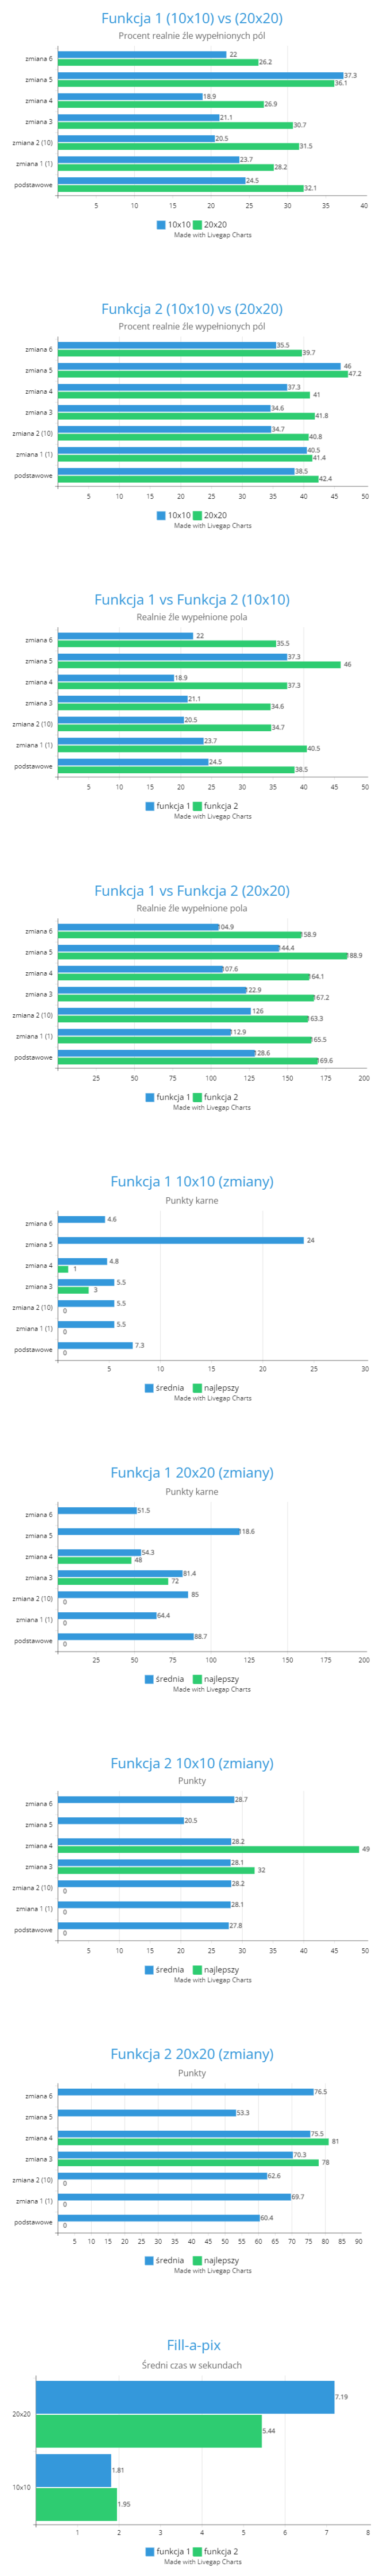

In [12]:
# pobierania obrazków
ag1 = mpimg.imread('./Funkcja 1 (10x10) vs (20x20).PNG')
ag2 = mpimg.imread('./Funkcja 2 (10x10) vs (20x20).PNG')

ag3 = mpimg.imread('./Funkcja 1 vs Funkcja 2 (10x10).PNG')
ag4 = mpimg.imread('./Funkcja 1 vs Funkcja 2 (20x20).PNG')

ag5 = mpimg.imread('./Funkcja 1 10x10 (zmiany).PNG')
ag6 = mpimg.imread('./Funkcja 1 20x20 (zmiany).PNG')

ag7 = mpimg.imread('./Funkcja 2 10x10 (zmiany).PNG')
ag8 = mpimg.imread('./Funkcja 2 20x20 (zmiany).PNG')

ag9 = mpimg.imread('./Fill-a-pix times.PNG')

# tworzymy pojemnik, w którym będą obrazki
fig = plt.figure(figsize=(20, 100))

# 3 obrazki w 1 rzędzie
rows = 9
columns = 1

fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(ag1)
plt.axis('off')

fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(ag2)
plt.axis('off')

fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(ag3)
plt.axis('off')

fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(ag4)
plt.axis('off')

fig.add_subplot(rows, columns, 5)

# showing image
plt.imshow(ag5)
plt.axis('off')

fig.add_subplot(rows, columns, 6)

# showing image
plt.imshow(ag6)
plt.axis('off')

fig.add_subplot(rows, columns, 7)

# showing image
plt.imshow(ag7)
plt.axis('off')

fig.add_subplot(rows, columns, 8)

# showing image
plt.imshow(ag8)
plt.axis('off')

fig.add_subplot(rows, columns, 9)

# showing image
plt.imshow(ag9)
plt.axis('off')

#### Przy porównywaniu czasów użyte ustawienia to:
* sol_per_pop = 30
* num_genes = 100
* num_parents_mating = 8
* num_generations = 190
* keep_parents = 4
* parent_selection_type = "sss"
* crossover_type = "two_points"
* mutation_percent_genes = 1
* mutation_type = "random"

### Teraz rój cząstek oraz fill-a-pix 10x10 (funkcja 1)
---

### Funkcja, na której działają cząsteczki nr 1 (fill-a-pix 10x10)

##### Pomysł na funkcje:
1. Znajdujemy bloczek z liczbą inną niż "-1".
2. Liczymy ile jest czarnych bloczków
3. Patrzymy o ile się różni ta liczba od tego ile być powinno
4. Sumujemy punkty karne.
5. Dążymy do tego by punktów karnych nie było, czyli dążymy do zera.
Plan jest taki sam, ale punktu karne są dodatnie, ponieważ rój szuka minimum.
Czyli im mniej, tym lepiej.

Nasza funkcja przyjmuje jako argument "params", czyli listę 100 zer i jedynek.


Trzeba ją zmienić na listę list 10x10, żeby móc ją porównać z naszym fillAPix10x10.
Do tego wykorzystam ny funkcję "change_to_list_of_lists"
Tutaj tak samo, jak poprzednio.

### Blok gdzie tworzymy naszą funkcję.

In [9]:
def function1(params):
    # liczymy punkty karne, idealnie = brak punktów karnych
    penalty_points = 0

    # długość jednego rzędu
    length = int(sqrt(len(params)))

    # params jest wypełniony zerami i jedynkami, zero = białe pole, jedynka = czarne pole
    solution_10_x_10 = change_to_list_of_lists(params, length)

    for i1 in range(10):
        for i2 in range(10):
            if fill_a_pix_10_x_10[i1][i2] != -1:
                # sprawdź ile czarnych pól jest
                # przy sumowanie wystarczy sumować wartości pól, bo czarne pole to 1, a białe to 0

                # odpowiednia liczba czarnych bloczków to wartość pola obrazka w formie tablicy tablic
                correct_number_of_black_blocks = fill_a_pix_10_x_10[i1][i2]

                # na starcie do sumy dodajemy wartość pola, które analizujemy i ilość czarnych pól dookoła
                number_of_black_blocks = solution_10_x_10[i1][i2] + get_number_of_black_pixels_around_this_pixel(i1, i2, solution_10_x_10, length)

                # o ile od prawidłowej liczby czarnych bloków różniła się uzyskana liczba bloków
                penalty_points += abs(correct_number_of_black_blocks - number_of_black_blocks)

    return penalty_points

# każda cząstka sprawdza jaki wynik dostanie z naszej funkcji,
# by móc szukać minimum
def f(x):
    # pobieramy ilość cząstek
    n_particles = x.shape[0]
    # na każdej cząstce używamy naszej funkcji
    j = [function1(x[i]) for i in range(n_particles)]
    return np.array(j)

### Blok gdzie uruchamiamy nasz algorytm. (fill-a-pix 10x10) (funkcja 1)

In [10]:
# do liczenia średniej czasu
average_time = 0

# do liczenia średniej rezultatów
results = 0

# do liczenia średniej realnie źle wypełnionych bloczków
real_result = 0

# opis ustawień
# c1 = współczynnik dążenia do najlepszego indywidualnego rozwiązania
# c2 = współczynnik dążenia do najlepszego lokalnego rozwiązania
# w = współczynnik bezwładności, określa wpływ prędkości z poprzedniego kroku
# k = ilość sąsiadów do rozważenia
# p = jaką normę Minkowskiego stosujemy
#   1 - to suma wartości bezwzględnych
#   2 - to odległość euklidesowa

# ustawienia do psoBinary
# psoBinary generuje listy zer i jedynek, więc nie ma problemu
# options = {'c1': 0.3, 'c2': 0.9, 'w':0.9, 'k':2, 'p':1}

# ustawienia do globalBestPSO
# globalBestPSO generuje liczby zmienno przecinkowe z danego zakresu
# natomiast funlcka "change_to_list_of_lists" zaokrągla liczby które nie są zerami i jedynkami więc nie ma problemu
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Wprowadzamy ograniczenia,
# ponieważ liczby generowane przez algorytm globalBestPSO muszą być z zakresu [0,1].
# Potem te liczby można łatwo zaokrąglić do zer i jedynek i tak otrzymywać wyniki, jak w psoBinary.
x_max = np.ones(100)
x_min = np.zeros(100)
my_bounds = (x_min, x_max)

# pętla do wielokrotnego uruchamiania algorytmu, do testów
for i in range(10):
    # zaczynamy liczyć czas
    start = time.time()

    # dimenstions=100, ponieważ tworzymy algorytm ma generować listy 100 elementowe

    #--------------------------------------------------------------------
    # Używamy GlobalBestPSO
    optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=100,
                                        options=options, bounds=my_bounds)

    #--------------------------------------------------------------------------------
    # Używamy BinaryPSO
    # optimizer = ps.discrete.BinaryPSO(n_particles=10, dimensions=100,
    #                                   options=options)
    #----------------------------------------------------------------------------------------

    # uruchamiamy nasz algorytm
    # iters = 1000, funkcja "f" która jest wyżej wykonuje się 1000 razy
    cost, pos = optimizer.optimize(f, iters=1000) #1000

    # liczymy ile czasu działał algorytm i dodajemy, by policzyć średnią
    end = time.time()
    average_time += (end - start)

    # pobieramy jak najlepszy wynik udało nam się osiągnąć
    results += cost

    # cost_history = optimizer.cost_history
    # plot_cost_history(cost_history)
    # plt.show()

    # do analizy potrzebujemy, żeby nasz wynik był listą list
    solution_10_x_10 = change_to_list_of_lists(pos, 10)

    # liczenie realnej liczby źle uzupełnionych bloczków
    number_of_wrong_pixels = 0

    # policzenie realnej ilość błędnie uzupełnionych pexeli porównując z rozwiązaniem
    for i1 in range (10):
        for i2 in range (10):
            if fill_a_pix_10_x_10_solution[i1][i2] != solution_10_x_10[i1][i2]:
                number_of_wrong_pixels += 1

    real_result += number_of_wrong_pixels

print("średnia karnych punktów: ", results/10)
print("średnia realnie źle wypełnionych bloczków: ", real_result/10)
print("średni czas: ", average_time/10)

2022-04-18 20:23:05,437 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=19
2022-04-18 20:23:11,117 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 19.0, best pos: [0.60594302 0.3747241  0.48354763 0.73163681 0.44069641 0.11102188
 0.23413854 0.55765465 0.59247109 0.75790917 0.19285481 0.62805437
 0.44766623 0.5155595  0.65066187 0.24967693 0.41074554 0.41466381
 0.77860057 0.40047556 0.67506468 0.76918842 0.43036794 0.47511067
 0.78175685 0.31715784 0.12426629 0.62488499 0.66933297 0.81042213
 0.58038398 0.54876132 0.30332189 0.73957791 0.70632616 0.33944227
 0.21645037 0.62254259 0.54619263 0.491657   0.52913952 0.25273655
 0.4846461  0.54597115 0.79401857 0.69487197 0.96809831 0.6596359
 0.06237741 0.39422351 0.64037141 0.38050844 0.78434711 0.1534427
 0.38128996 0.3239954  0.4447628  0.06824446 0.01128833 0.51914923
 0.92353954 0.61544411 0

średnia karnych punktów:  18.6
średnia realnie źle wypełnionych bloczków:  31.3
średni czas:  5.17347822189331


#### Testowanie obrazka 10x10
##### Podstawowe Ustawienia:
* ps.discrete.BinaryPSO (topologia ring)
* options = {'c1': 0.5, 'c2': 0.3, 'w':0.9, 'k':2, 'p':1}
* n_particles = 10
* dimensions = 100
* iters = 1000

#### testy robione na 10 próbach
##### Obecne ustawienia:
* średnia karnych punktów: 28.2
* średnia realnie źle uzupełnionych bloczków: 36.2
* najlepszy wynik (punkty karne): 24

##### Zmiana 1
n_particles = 20, 50
* 20 - średnia karnych punktów: 26.7
* 20 - średnia realnie źle uzupełnionych bloczków: 34.4
* 20 - najlepszy wynik (punkty karne): 24
*
* 50 - średnia karnych punktów: 25.6
* 50 - średnia realnie źle uzupełnionych bloczków: 33.6
* 50 - najlepszy wynik (punkty karne): 20
Zwiększenie liczby cząstek szukających minimum znacząco poprawia wyniki.
Spora różnica w najlepszym wyniku między "20" a "50".
Choć widoczne jest też znaczące spowolnienie algorytmu.

##### Zmiana 2
w: 0.5
* średnia karnych punktów: 32.8
* średnia realnie źle uzupełnionych bloczków: 37.8
* najlepszy wynik (punkty karne): 30
Bardziej chaotyczne ruchy cząstek nie wpływają pozytywnie na wynik.

##### Zmiana 3
c1: 0.7, 0.9
* 0.7 - średnia karnych punktów: 26.5
* 0.7 - średnia realnie źle uzupełnionych bloczków: 35.0
* 0.7 - najlepszy wynik (punkty karne): 23
*
* 0.9 - średnia karnych punktów: 26.0
* 0.9 - średnia realnie źle uzupełnionych bloczków: 34.0
* 0.9 - najlepszy wynik (punkty karne): 23

Większe dążenia do najlepszego indywidualnego rozwiązania poprawiło wyniki.

##### Zmiana 4
c2: 0.7, 0.9
c1: 0.3
* 0.7 - średnia karnych punktów: 27.4
* 0.7 - średnia realnie źle uzupełnionych bloczków: 35.6
* 0.7 - najlepszy wynik (punkty karne): 25
*
* 0.9 - średnia karnych punktów: 24.9
* 0.9 - średnia realnie źle uzupełnionych bloczków: 34.3
* 0.9 - najlepszy wynik (punkty karne): 21
W kwestii dążenia do najlepszego lokalnego rozwiązania,
"0.7" trochę poprawiło wyniki, natomiast "0.9" znacznie je poprawiło.
Natomiast powiększone c2 do "0.9", lepiej wpłynęło na wyniki niż powiększone c1.

##### Zmiana 5
ps.single.GlobalBestPSO (topologia = star)
* średnia karnych punktów: 16.5
* średnia realnie źle uzupełnionych bloczków: 30.9
* najlepszy wynik (punkty karne): 12
GlobalBestPSO, który generuje liczby z przedziału i z pomocą zaokrąglania tych liczb otrzymujemy zera i jedynki, wydaje się, jakby to miało działać gorzej, a jednak działa dużo lepiej.

##### Zmiana 6
c1: 0.9, c2: 0.3
ps.single.GlobalBestPSO (topologia = star)
* średnia karnych punktów: 22.6
* średnia realnie źle uzupełnionych bloczków: 32.5
* najlepszy wynik (punkty karne): 17
Tym razem powiększone większe dążenia do najlepszego indywidualnego rozwiązania negatywnie wpłynęło na wyniki.

##### Zmiana 7
c1: 0.3, c2: 0.9
ps.single.GlobalBestPSO (topologia = star)
* średnia karnych punktów: 25.9
* średnia realnie źle uzupełnionych bloczków: 33.6
* najlepszy wynik (punkty karne): 20
W kwestii dążenia do najlepszego lokalnego rozwiązania, wynik tutaj się pogorszył.

### Teraz fill-a-pix 20x20 (funkcja 1)

In [31]:
number = 0

#### Blok gdzie tworzymy naszą funkcję, pod fill-a-pix 20x20.

In [34]:
def function1_20_x_20(params):
    # liczymy punkty karne, idealnie = brak punktów karnych
    penalty_points = 0

    # długość jednego rzędu
    length = int(sqrt(len(params)))

    # params jest wypełniony zerami i jedynkami, zero = białe pole, jedynka = czarne pole
    solution_20_x_20 = change_to_list_of_lists(params, length)

    for i1 in range(20):
        for i2 in range(20):
            if fill_a_pix_20_x_20[i1][i2] != -1:
                # sprawdź ile czarnych pól jest
                # przy sumowanie wystarczy sumować wartości pól, bo czarne pole to 1, a białe to 0

                # odpowiednia liczba czarnych bloczków to wartość pola obrazka w formie tablicy tablic
                correct_number_of_black_blocks = fill_a_pix_20_x_20[i1][i2]

                # na starcie do sumy dodajemy wartość pola, które analizujemy i ilość czarnych pól dookoła
                number_of_black_blocks = solution_20_x_20[i1][i2] + get_number_of_black_pixels_around_this_pixel(i1, i2, solution_20_x_20, length)

                # o ile od prawidłowej liczby czarnych bloków różniła się uzyskana liczba bloków
                penalty_points += abs(correct_number_of_black_blocks - number_of_black_blocks)

    return penalty_points

# każda cząstka sprawdza jaki wynik dostanie z naszej funkcji,
# by móc szukać minimum
def f(x):
    # pobieramy ilość cząstek
    n_particles = x.shape[0]
    # na każdej cząstce używamy naszej funkcji
    j = [function1_20_x_20(x[i]) for i in range(n_particles)]

    return np.array(j)

### Blok gdzie uruchamiamy nasz algorytm. (fill-a-pix 20x20) (funkcja 1)

In [36]:
#number = 0

# do liczenia średniej czasu
average_time = 0

# do liczenia średniej rezultatów
results = 0

# do liczenia średniej realnie źle wypełnionych bloczków
real_result = 0

# czyścimy z poprzednich obrazków do animacji
fill_a_pix_20_x_20_images = []

# opis ustawień
# c1 = współczynnik dążenia do najlepszego indywidualnego rozwiązania
# c2 = współczynnik dążenia do najlepszego lokalnego rozwiązania
# w = współczynnik bezwładności, określa wpływ prędkości z poprzedniego kroku
# k = ilość sąsiadów do rozważenia
# p = jaką normę Minkowskiego stosujemy
#   1 - to suma wartości bezwzględnych
#   2 - to odległość euklidesowa

# ustawienia do psoBinary
# psoBinary generuje listy zer i jedynek, więc nie ma problemu
# options = {'c1': 0.3, 'c2': 0.9, 'w':0.9, 'k':2, 'p':1}

# ustawienia do globalBestPSO
# globalBestPSO generuje liczby zmienno przecinkowe z danego zakresu
# natomiast funlcka "change_to_list_of_lists" zaokrągla liczby które nie są zerami i jedynkami więc nie ma problemu
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Wprowadzamy ograniczenia,
# ponieważ liczby generowane przez algorytm muszą być z zakresu [0,1].
# Potem te liczby można łatwo zaokrąglić do zer i jedynek i tak otrzymywać wyniki, jak w psoBinary.
x_max = np.ones(400)
x_min = np.zeros(400)
my_bounds = (x_min, x_max)

# pętla do wielokrotnego uruchamiania algorytmu, do testów
for i in range(1):
    # zaczynamy liczyć czas
    start = time.time()

    # dimenstions=100, ponieważ tworzymy listę 100 elementów

    #--------------------------------------------------------------------
    # Używamy GlobalBestPSO
    optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=400,
                                        options=options, bounds=my_bounds)

    #--------------------------------------------------------------------------------
    # Używamy BinaryPSO
    # optimizer = ps.discrete.BinaryPSO(n_particles=10, dimensions=400,
    #                                   options=options)
    #----------------------------------------------------------------------------------------

    # uruchamiamy nasz algorytm
    # iters = 1000, funkcja "f" która jest wyżej wykonuje się 1000 razy
    cost, pos = optimizer.optimize(f, iters=100) #1000

    # liczymy ile czasu działał algorytm i dodajemy, by policzyć średnią
    end = time.time()
    average_time += (end - start)

    # pobieramy jak najlepszy wynik udało nam się osiągnąć
    results += cost

    # cost_history = optimizer.cost_history
    # plot_cost_history(cost_history)
    # plt.show()

    solution_20_x_20 = change_to_list_of_lists(pos, 20)

    # liczenie realnej liczby źle uzupełnionych bloczków
    number_of_wrong_pixels = 0

    # policzenie realnej ilość błędnie uzupełnionych pexeli porównując z rozwiązaniem
    for i1 in range (20):
        for i2 in range (20):
            if fill_a_pix_20_x_20_solution[i1][i2] != solution_20_x_20[i1][i2]:
                number_of_wrong_pixels += 1

    real_result += number_of_wrong_pixels

print("średnia karnych punktów: ", results/1)
print("średnia realnie źle wypełnionych bloczków: ", real_result/1)
print("średni czas: ", average_time/1)

2022-04-20 03:32:48,952 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=210
2022-04-20 03:32:49,815 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 210.0, best pos: [0.86192417 0.70157282 0.35454766 0.50110611 0.17719588 0.83041727
 0.01970647 0.37648662 0.80955777 0.62204839 0.64501091 0.13718332
 0.43337026 0.76236521 0.23725759 0.38157014 0.25684516 0.40970381
 0.3611335  0.17530636 0.39213589 0.75235876 0.93120813 0.63838479
 0.34084069 0.81748396 0.52715095 0.77159374 0.50427726 0.52519676
 0.77390876 0.45118661 0.3536666  0.52508363 0.92813796 0.40518137
 0.62393358 0.89954803 0.37537875 0.33396522 0.45858045 0.22890328
 0.5795877  0.13497128 0.92716888 0.80627574 0.66523885 0.68041833
 0.81854003 0.96538485 0.43597496 0.5161036  0.25880978 0.32200401
 0.55186303 0.73850778 0.50414067 0.601856   0.56044848 0.59962924
 0.18624904 0.32773683 

średnia karnych punktów:  210.0
średnia realnie źle wypełnionych bloczków:  168.0
średni czas:  0.8699996471405029


#### Testowanie obrazka 10x10
##### Podstawowe Ustawienia:
* ps.discrete.BinaryPSO (topologia ring)
* options = {'c1': 0.5, 'c2': 0.3, 'w':0.9, 'k':2, 'p':1}
* n_particles = 10
* dimensions = 100
* iters = 1000

#### testy robione na 10 próbach
##### Obecne ustawienia:
* średnia karnych punktów: 189.7
* realnie źle uzupełnione bloczki: 172.0
* najlepszy wynik (punkty karne): 178

##### Zmiana 1
n_particles = 20, 50
* 20 - średnia karnych punktów: 183.6
* 20 - średnia realnie źle uzupełnionych bloczków: 168.2
* 20 - najlepszy wynik (punkty karne): 174
*
* 50 - średnia karnych punktów: 183.2
* 50 - średnia realnie źle uzupełnionych bloczków: 165.9
* 50 - najlepszy wynik (punkty karne): 174
Zwiększenie liczby cząstek szukających minimum znowu poprawia wyniki.
Tym razem mała różnica w średniej i brak różnicy w najlepszym wyniku między "20" a "50".
Natomiast tym razem dużo bardziej zwiększa czas działania algorytmy.

##### Zmiana 2
w: 0.5
* średnia karnych punktów: 211
* średnia realnie źle uzupełnionych bloczków: 174.9
* najlepszy wynik (punkty karne): 208
Bardziej chaotyczne ruchy cząstek tym razem też nie wpływają pozytywnie na wynik.

##### Zmiana 3
c1: 0.7, 0.9
* 0.7 - średnia karnych punktów: 184.1
* 0.7 - średnia realnie źle uzupełnionych bloczków: 166.7
* 0.7 - najlepszy wynik (punkty karne): 180
*
* 0.9 - średnia karnych punktów: 181.2
* 0.9 - średnia realnie źle uzupełnionych bloczków: 163.9
* 0.9 - najlepszy wynik (punkty karne): 173

Większe dążenia do najlepszego indywidualnego rozwiązania ponownie poprawiło wyniki.

##### Zmiana 4
c2: 0.7, 0.9
c1: 0.3
* 0.7 - średnia karnych punktów: 185.0
* 0.7 - średnia realnie źle uzupełnionych bloczków: 166.2
* 0.7 - najlepszy wynik (punkty karne): 174
*
* 0.9 - średnia karnych punktów: 179.5
* 0.9 - średnia realnie źle uzupełnionych bloczków: 166.3
* 0.9 - najlepszy wynik (punkty karne): 163
W kwestii dążenia do najlepszego lokalnego rozwiązania,
"0.7" trochę poprawiło wyniki, ale nie tak dobrze, jak "0.7" przy zmianie 3.
"0.9" ponownie znacznie je poprawiło.
Ponownie powiększone c2 do "0.9", lepiej wpłynęło na wyniki niż powiększone c1.

##### Zmiana 5
ps.single.GlobalBestPSO (topologia = star)
* średnia karnych punktów: 139.6
* średnia realnie źle uzupełnionych bloczków: 149.9
* najlepszy wynik (punkty karne): 121
GlobalBestPSO, który generuje liczby z przedziału i z pomocą zaokrąglania tych liczb otrzymujemy zera i jedynki, wydaje się, jakby to miało działać gorzej, a jednak ponownie działa dużo lepiej.

##### Zmiana 6
c1: 0.9, c2: 0.3
ps.single.GlobalBestPSO (topologia = star)
* średnia karnych punktów: 157.5
* średnia realnie źle uzupełnionych bloczków: 155.3
* najlepszy wynik (punkty karne): 141
Powiększone większe dążenia do najlepszego indywidualnego rozwiązania ponownie w tej sytuacji, negatywnie wpłynęło na wyniki.

##### Zmiana 7
c1: 0.3, c2: 0.9
ps.single.GlobalBestPSO (topologia = star)
* średnia karnych punktów: 181.6
* średnia realnie źle uzupełnionych bloczków: 170.2
* najlepszy wynik (punkty karne): 153
W kwestii dążenia do najlepszego lokalnego rozwiązania, wynik ponownie się pogorszył.

### Funkcja nr 2 (fill-a-pix 10x10)

##### Pomysł na funkcje:
1. Znajdujemy bloczek z liczbą inną niż "-1".
2. Liczymy ile jest czarnych bloczków.
3. Patrzymy czy liczba czarnych bloczków się zgadza.
4. Jeżeli się zgadza dajemy punkt.
5. Dążymy do tego, by punktów było jak najwięcej.
Natomiast tutaj szukane jest minimum więc zmienamy punkty na minusy.
Im mniej, tym lepiej.

Nasza funkcja przyjmuje jako argument "params", czyli listę 100 zer i jedynek.


Trzeba ją zmienić na listę list 10x10, żeby móc ją porównać z naszym fillAPix10x10.
Do tego wykorzystam ny funkcję "change_to_list_of_lists"
Tutaj tak samo, jak poprzednio.

### Blok gdzie tworzymy naszą funkcję.

In [13]:
def function2_10_x_10(params):
    # liczymy punkty
    reward_points = 0

    # długość jednego rzędu
    length = int(sqrt(len(params)))

    # params jest wypełniony zerami i jedynkami, zero = białe pole, jedynka = czarne pole
    solution_10_x_10 = change_to_list_of_lists(params, length)

    for i1 in range(10):
        for i2 in range(10):
            if fill_a_pix_10_x_10[i1][i2] != -1:
                # sprawdź ile czarnych pól jest
                # przy sumowanie wystarczy sumować wartości pól, bo czarne pole to 1, a białe to 0

                # odpowiednia liczba czarnych bloczków to wartość pola obrazka w formie tablicy tablic
                correct_number_of_black_blocks = fill_a_pix_10_x_10[i1][i2]

                # na starcie do sumy dodajemy wartość pola, które analizujemy i ilość czarnych pól dookoła
                number_of_black_blocks = solution_10_x_10[i1][i2] + get_number_of_black_pixels_around_this_pixel(i1, i2, solution_10_x_10, length)

                # jeżeli liczba czarnych bloczków jest tak jak oczekiwana liczba czarnych bloczków dostajemy punkt
                if correct_number_of_black_blocks == number_of_black_blocks:
                    reward_points -= 1

    return reward_points

# każda cząstka sprawdza jaki wynik dostanie z naszej funkcji,
# by móc szukać minimum
def f(x):
    # pobieramy ilość cząstek
    n_particles = x.shape[0]
    # na każdej cząstce używamy naszej funkcji
    j = [function2_10_x_10(x[i]) for i in range(n_particles)]
    return np.array(j)

### Blok gdzie uruchamiamy nasz algorytm. (fill-a-pix 10x10) (funkcja 2)

In [14]:
# do liczenia średniej czasu
average_time = 0

# do liczenia średniej rezultatów
results = 0

# do liczenia średniej realnie źle wypełnionych bloczków
real_result = 0

# opis ustawień
# c1 = współczynnik dążenia do najlepszego indywidualnego rozwiązania
# c2 = współczynnik dążenia do najlepszego lokalnego rozwiązania
# w = współczynnik bezwładności, określa wpływ prędkości z poprzedniego kroku
# k = ilość sąsiadów do rozważenia
# p = jaką normę Minkowskiego stosujemy
#   1 - to suma wartości bezwzględnych
#   2 - to odległość euklidesowa

# ustawienia do psoBinary
# psoBinary generuje listy zer i jedynek, więc nie ma problemu
# options = {'c1': 0.3, 'c2': 0.9, 'w':0.9, 'k':2, 'p':1}

# ustawienia do globalBestPSO
# globalBestPSO generuje liczby zmienno przecinkowe z danego zakresu
# natomiast funlcka "change_to_list_of_lists" zaokrągla liczby które nie są zerami i jedynkami więc nie ma problemu
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Wprowadzamy ograniczenia,
# ponieważ liczby generowane przez algorytm muszą być z zakresu [0,1].
# Potem te liczby można łatwo zaokrąglić do zer i jedynek i tak otrzymywać wyniki, jak w psoBinary.
x_max = np.ones(100)
x_min = np.zeros(100)
my_bounds = (x_min, x_max)

# pętla do wielokrotnego uruchamiania algorytmu, do testów
for i in range(10):
    # zaczynamy liczyć czas
    start = time.time()

    # dimenstions=100, ponieważ tworzymy listę 100 elementów

    #--------------------------------------------------------------------
    # Używamy GlobalBestPSO
    optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=100,
                                        options=options, bounds=my_bounds)

    #--------------------------------------------------------------------------------
    # Używamy BinaryPSO
    # optimizer = ps.discrete.BinaryPSO(n_particles=10, dimensions=100,
    #                                   options=options)
    #----------------------------------------------------------------------------------------

    # uruchamiamy nasz algorytm
    # iters = 1000, funkcja "f" która jest wyżej wykonuje się 1000 razy
    cost, pos = optimizer.optimize(f, iters=1000) #1000

    # liczymy ile czasu działał algorytm i dodajemy, by policzyć średnią
    end = time.time()
    average_time += (end - start)

    # pobieramy jak najlepszy wynik (punkty karne) udało nam się osiągnąć
    results += cost

    # cost_history = optimizer.cost_history
    # plot_cost_history(cost_history)
    # plt.show()

    solution_10_x_10 = change_to_list_of_lists(pos, 10)

    # liczenie realnej liczby źle uzupełnionych bloczków
    number_of_wrong_pixels = 0

    # policzenie realnej ilość błędnie uzupełnionych pexeli porównując z rozwiązaniem
    for i1 in range (10):
        for i2 in range (10):
            if fill_a_pix_10_x_10_solution[i1][i2] != solution_10_x_10[i1][i2]:
                number_of_wrong_pixels += 1

    real_result += number_of_wrong_pixels

print("średnia punktów: ", results/10)
print("średnia realnie źle wypełnionych bloczków: ", real_result/10)
print("średni czas: ", average_time/10)

2022-04-18 20:32:31,186 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-22
2022-04-18 20:32:37,376 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -22.0, best pos: [0.38510698 0.4985775  0.59068384 0.71581356 0.42008887 0.45632979
 0.43194442 0.52477142 0.61146699 0.60085517 0.34701013 0.04480886
 0.56622971 0.29372728 0.35452591 0.45283046 0.4723411  0.4368272
 0.58400515 0.66672167 0.21185844 0.52716581 0.5180006  0.61720992
 0.48674544 0.82719867 0.56347731 0.4582783  0.52169946 0.66047683
 0.41365204 0.49351329 0.63112006 0.49754418 0.54806894 0.60635487
 0.40719278 0.52160393 0.59810459 0.70032888 0.09222744 0.2596107
 0.72853913 0.3230479  0.32795056 0.56746751 0.49488789 0.57861168
 0.40812093 0.41287185 0.64331114 0.55730185 0.46622205 0.50570769
 0.16608247 0.55637271 0.57166331 0.30364433 0.36893952 0.68615459
 0.54175664 0.81534222

średnia punktów:  -20.2
średnia realnie źle wypełnionych bloczków:  45.5
średni czas:  5.5371338605880736


#### Testowanie obrazka 10x10, funkcja 2
##### Podstawowe Ustawienia:
* ps.discrete.BinaryPSO (topologia ring)
* options = {'c1': 0.5, 'c2': 0.3, 'w':0.9, 'k':2, 'p':1}
* n_particles = 10
* dimensions = 100
* iters = 1000

#### testy robione na 10 próbach
##### Obecne ustawienia:
* średnia punktów: -17.7
* średnia realnie źle uzupełnionych bloczków: 45.6
* najlepszy wynik (punkty karne): -19

##### Zmiana 1
n_particles = 20, 50
* 20 - średnia punktów: -17.9
* 20 - średnia realnie źle uzupełnionych bloczków: 44.2
* 20 - najlepszy wynik (punkty karne): -20
*
* 50 - średnia punktów: -18.8
* 50 - średnia realnie źle uzupełnionych bloczków: 44.0
* 50 - najlepszy wynik (punkty karne): -20
Zwiększenie liczby cząstek szukających minimum tym razem lekko poprawia wyniki.
Tym razem brak różnicy w najlepszym wyniku między "20" a "50" oraz tylko lekka różnica w średniej punktów.
Choć widoczne jest też znaczące spowolnienie algorytmu.

##### Zmiana 2
w: 0.5
* średnia punktów: -16.6
* średnia realnie źle uzupełnionych bloczków: 46.5
* najlepszy wynik (punkty karne): -18
Bardziej chaotyczne ruchy cząstek ponownie, nie wpływają pozytywnie na wynik.

##### Zmiana 3
c1: 0.7, 0.9
* 0.7 - średnia punktów: -17.7
* 0.7 - średnia realnie źle uzupełnionych bloczków: 43.0
* 0.7 - najlepszy wynik (punkty karne): -19
*
* 0.9 - średnia punktów: -18.6
* 0.9 - średnia realnie źle uzupełnionych bloczków: 44.1
* 0.9 - najlepszy wynik (punkty karne): -20

Większe dążenia do najlepszego indywidualnego rozwiązania ponownie poprawiło wyniki,
ale tylko "0.9".

##### Zmiana 4
c2: 0.7, 0.9
c1: 0.3
* 0.7 - średnia punktów: -18.0
* 0.7 - średnia realnie źle uzupełnionych bloczków: 43.3
* 0.7 - najlepszy wynik (punkty karne): -19
*
* 0.9 - średnia punktów: -17.9
* 0.9 - średnia realnie źle uzupełnionych bloczków: 45.0
* 0.9 - najlepszy wynik (punkty karne): -20
W kwestii dążenia do najlepszego lokalnego rozwiązania,
"0.7" ponownie, trochę poprawiło wyniki, natomiast "0.9" też poprawiło je tylko trochę.
Tym razem powiększone c1 dało lepsze rezultaty.

##### Zmiana 5
ps.single.GlobalBestPSO (topologia = star)
* średnia punktów: -17.9
* średnia realnie źle uzupełnionych bloczków: 45.0
* najlepszy wynik (punkty karne): -20
GlobalBestPSO, który generuje liczby z przedziału i z pomocą zaokrąglania tych liczb otrzymujemy zera i jedynki, wydaje się, jakby to miało działać gorzej, ale tym razem tylko trochę poprawił wyniki.

##### Zmiana 6
c1: 0.9, c2: 0.3
ps.single.GlobalBestPSO (topologia = star)
* średnia punktów: -18.0
* średnia realnie źle uzupełnionych bloczków: 45.8
* najlepszy wynik (punkty karne): -20
Tym razem powiększone większe dążenia do najlepszego indywidualnego rozwiązania lekko pozytywnie wpłynęło na wyniki.

##### Zmiana 7
c1: 0.3, c2: 0.9
ps.single.GlobalBestPSO (topologia = star)
* średnia punktów: -17.8
* średnia realnie źle uzupełnionych bloczków: 46.0
* najlepszy wynik (punkty karne): -19
W kwestii dążenia do najlepszego lokalnego rozwiązania, wynik tutaj się również lekko poprawił.

### Teraz fill-a-pix 20x20 (funkcja 2)

#### Blok gdzie tworzymy naszą funkcję, pod fill-a-pix 20x20.

In [15]:
def function2_20_x_20(params):
    # liczymy punkty
    reward_points = 0

    # długość jednego rzędu
    length = int(sqrt(len(params)))

    # params jest wypełniony zerami i jedynkami, zero = białe pole, jedynka = czarne pole
    solution_20_x_20 = change_to_list_of_lists(params, length)

    for i1 in range(20):
        for i2 in range(20):
            if fill_a_pix_20_x_20[i1][i2] != -1:
                # sprawdź ile czarnych pól jest
                # przy sumowanie wystarczy sumować wartości pól, bo czarne pole to 1, a białe to 0

                # odpowiednia liczba czarnych bloczków to wartość pola obrazka w formie tablicy tablic
                correct_number_of_black_blocks = fill_a_pix_20_x_20[i1][i2]

                # na starcie do sumy dodajemy wartość pola, które analizujemy i ilość czarnych pól dookoła
                number_of_black_blocks = solution_20_x_20[i1][i2] + get_number_of_black_pixels_around_this_pixel(i1, i2, solution_20_x_20, length)

                # jeżeli liczba czarnych bloczków jest tak jak oczekiwana liczba czarnych bloczków dostajemy punkt
                if correct_number_of_black_blocks == number_of_black_blocks:
                    reward_points -= 1

    return reward_points

# każda cząstka sprawdza jaki wynik dostanie z naszej funkcji,
# by móc szukać minimum
def f(x):
    # pobieramy ilość cząstek
    n_particles = x.shape[0]
    # na każdej cząstce używamy naszej funkcji
    j = [function2_20_x_20(x[i]) for i in range(n_particles)]
    return np.array(j)

### Blok gdzie uruchamiamy nasz algorytm. (fill-a-pix 20x20) (funkcja 2)

In [16]:
# do liczenia średniej czasu
average_time = 0

# do liczenia średniej rezultatów
results = 0

# do liczenia średniej realnie źle wypełnionych bloczków
real_result = 0

# opis ustawień
# c1 = współczynnik dążenia do najlepszego indywidualnego rozwiązania
# c2 = współczynnik dążenia do najlepszego lokalnego rozwiązania
# w = współczynnik bezwładności, określa wpływ prędkości z poprzedniego kroku
# k = ilość sąsiadów do rozważenia
# p = jaką normę Minkowskiego stosujemy
#   1 - to suma wartości bezwzględnych
#   2 - to odległość euklidesowa

# ustawienia do psoBinary
# psoBinary generuje listy zer i jedynek, więc nie ma problemu
# options = {'c1': 0.3, 'c2': 0.9, 'w':0.9, 'k':2, 'p':1}

# ustawienia do globalBestPSO
# globalBestPSO generuje liczby zmienno przecinkowe z danego zakresu
# natomiast funlcka "change_to_list_of_lists" zaokrągla liczby które nie są zerami i jedynkami więc nie ma problemu
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Wprowadzamy ograniczenia,
# ponieważ liczby generowane przez algorytm muszą być z zakresu [0,1].
# Potem te liczby można łatwo zaokrąglić do zer i jedynek i tak otrzymywać wyniki, jak w psoBinary.
x_max = np.ones(400)
x_min = np.zeros(400)
my_bounds = (x_min, x_max)

# pętla do wielokrotnego uruchamiania algorytmu, do testów
for i in range(10):
    # zaczynamy liczyć czas
    start = time.time()

    # dimenstions=400, ponieważ tworzymy listę 400 elementów

    #--------------------------------------------------------------------
    # Używamy GlobalBestPSO
    optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=400,
                                        options=options, bounds=my_bounds)

    #--------------------------------------------------------------------------------
    # Używamy BinaryPSO
    # optimizer = ps.discrete.BinaryPSO(n_particles=10, dimensions=400,
    #                                   options=options)
    #----------------------------------------------------------------------------------------

    # uruchamiamy nasz algorytm
    # iters = 1000, funkcja "f" która jest wyżej wykonuje się 1000 razy
    cost, pos = optimizer.optimize(f, iters=1000) #1000

    # liczymy ile czasu działał algorytm i dodajemy, by policzyć średnią
    end = time.time()
    average_time += (end - start)

    # pobieramy jak najlepszy wynik (punkty karne) udało nam się osiągnąć
    results += cost

    # cost_history = optimizer.cost_history
    # plot_cost_history(cost_history)
    # plt.show()

    solution_20_x_20 = change_to_list_of_lists(pos, 20)

    # liczenie realnej liczby źle uzupełnionych bloczków
    number_of_wrong_pixels = 0

    # policzenie realnej ilość błędnie uzupełnionych pexeli porównując z rozwiązaniem
    for i1 in range (20):
        for i2 in range (20):
            if fill_a_pix_20_x_20_solution[i1][i2] != solution_20_x_20[i1][i2]:
                number_of_wrong_pixels += 1

    real_result += number_of_wrong_pixels

print("średnia punktów: ", results/10)
print("średnia realnie źle wypełnionych bloczków: ", real_result/10)
print("średni czas: ", average_time/10)

2022-04-18 20:35:13,293 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-43
2022-04-18 20:35:30,278 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -43.0, best pos: [0.56814843 0.62632424 0.42563377 0.69523585 0.66829689 0.56986518
 0.36732945 0.51532835 0.39371345 0.40576856 0.57011847 0.41694248
 0.45129457 0.77559339 0.38834565 0.34044065 0.34542966 0.29531693
 0.84162702 0.28624822 0.70968372 0.56156438 0.54382604 0.52937701
 0.50319861 0.50614747 0.54923671 0.46060538 0.28872505 0.53289348
 0.60665655 0.69499958 0.71061312 0.40030695 0.39533954 0.65356584
 0.20791071 0.60570192 0.31802241 0.47390595 0.63536548 0.62458421
 0.21795407 0.63224824 0.67361596 0.48692    0.57651253 0.70804318
 0.55681833 0.56852093 0.51380897 0.77956024 0.5237517  0.49605602
 0.46253666 0.28179579 0.62564197 0.46663296 0.43830438 0.74512708
 0.59127293 0.631472

średnia punktów:  -45.4
średnia realnie źle wypełnionych bloczków:  186.2
średni czas:  13.762680387496948


#### Testowanie obrazka 20x20, funkcja 2
##### Podstawowe Ustawienia:
* ps.discrete.BinaryPSO (topologia ring)
* options = {'c1': 0.5, 'c2': 0.3, 'w':0.9, 'k':2, 'p':1}
* n_particles = 10
* dimensions = 400
* iters = 1000

#### testy robione na 10 próbach
##### Obecne ustawienia:
* średnia punktów: -36.9
* średnia realnie źle uzupełnionych bloczków: 183.2
* najlepszy wynik (punkty karne): -39


##### Zmiana 1
n_particles = 20, 50
* 20 - średnia punktów: -37.6
* 20 - średnia realnie źle uzupełnionych bloczków: 182.5
* 20 - najlepszy wynik (punkty karne): -39
*
* 50 - średnia punktów: -43.7
* 50 - średnia realnie źle uzupełnionych bloczków: 181.9
* 50 - najlepszy wynik (punkty karne): -48
Zwiększenie liczby cząstek szukających minimum ponownie poprawia wyniki.
"20" lekko poprawia wynik, "50" mocno poprawia wynik.
Tym razem spora różnica w najlepszym wyniku między "20" a "50" oraz nie, mała różnica w średniej punktów.
Choć widoczne jest też jeszcze większe spowolnienie algorytmu.

##### Zmiana 2
w: 0.5
* średnia punktów: -35.1
* średnia realnie źle uzupełnionych bloczków: 188.9
* najlepszy wynik (punkty karne): -39
Bardziej chaotyczne ruchy cząstek ponownie, nie wpływają pozytywnie na wynik.

##### Zmiana 3
c1: 0.7, 0.9
* 0.7 - średnia punktów: -37.6
* 0.7 - średnia realnie źle uzupełnionych bloczków: 187.6
* 0.7 - najlepszy wynik (punkty karne): -40
*
* 0.9 - średnia punktów: -37.7
* 0.9 - średnia realnie źle uzupełnionych bloczków: 187.4
* 0.9 - najlepszy wynik (punkty karne): -40

Większe dążenia do najlepszego indywidualnego rozwiązania ponownie poprawiło wyniki.
Tym razem między "0.7" oraz "0.9" nie prawie rzadnej różnicy.

##### Zmiana 4
c2: 0.7, 0.9
c1: 0.3
* 0.7 - średnia punktów: -37.6
* 0.7 - średnia realnie źle uzupełnionych bloczków: 184.2
* 0.7 - najlepszy wynik (punkty karne): -42
*
* 0.9 - średnia punktów: -38.0
* 0.9 - średnia realnie źle uzupełnionych bloczków: 184.1
* 0.9 - najlepszy wynik (punkty karne): -40
W kwestii dążenia do najlepszego lokalnego rozwiązania,
"0.7" oraz "0.9" ponownie tylko lekko poprawiło wynik, choć jest między nimi większa różnica.
Tym razem powiększone c2 dało lepsze rezultaty.

##### Zmiana 5
ps.single.GlobalBestPSO (topologia = star)
* średnia punktów: -43.2
* średnia realnie źle uzupełnionych bloczków: 190.1
* najlepszy wynik (punkty karne): -51
GlobalBestPSO, który generuje liczby z przedziału i z pomocą zaokrąglania tych liczb otrzymujemy zera i jedynki, wydaje się, jakby to miało działać gorzej, sporo poprawił wyniki.

##### Zmiana 6
c1: 0.9, c2: 0.3
ps.single.GlobalBestPSO (topologia = star)
* średnia punktów: -38.2
* średnia realnie źle uzupełnionych bloczków: 186.9
* najlepszy wynik (punkty karne): -42
Tym razem powiększone większe dążenia do najlepszego indywidualnego rozwiązania negatywnie wpłynęło na wyniki.

##### Zmiana 7
c1: 0.3, c2: 0.9
ps.single.GlobalBestPSO (topologia = star)
* średnia punktów: -36.9
* średnia realnie źle uzupełnionych bloczków: 193.5
* najlepszy wynik (punkty karne): -40
W kwestii dążenia do najlepszego lokalnego rozwiązania, wynik tutaj się również pogorszył.

#### Podsumowanie powyższych testów w formie wykresów.

(-0.5, 699.5, 449.5, -0.5)

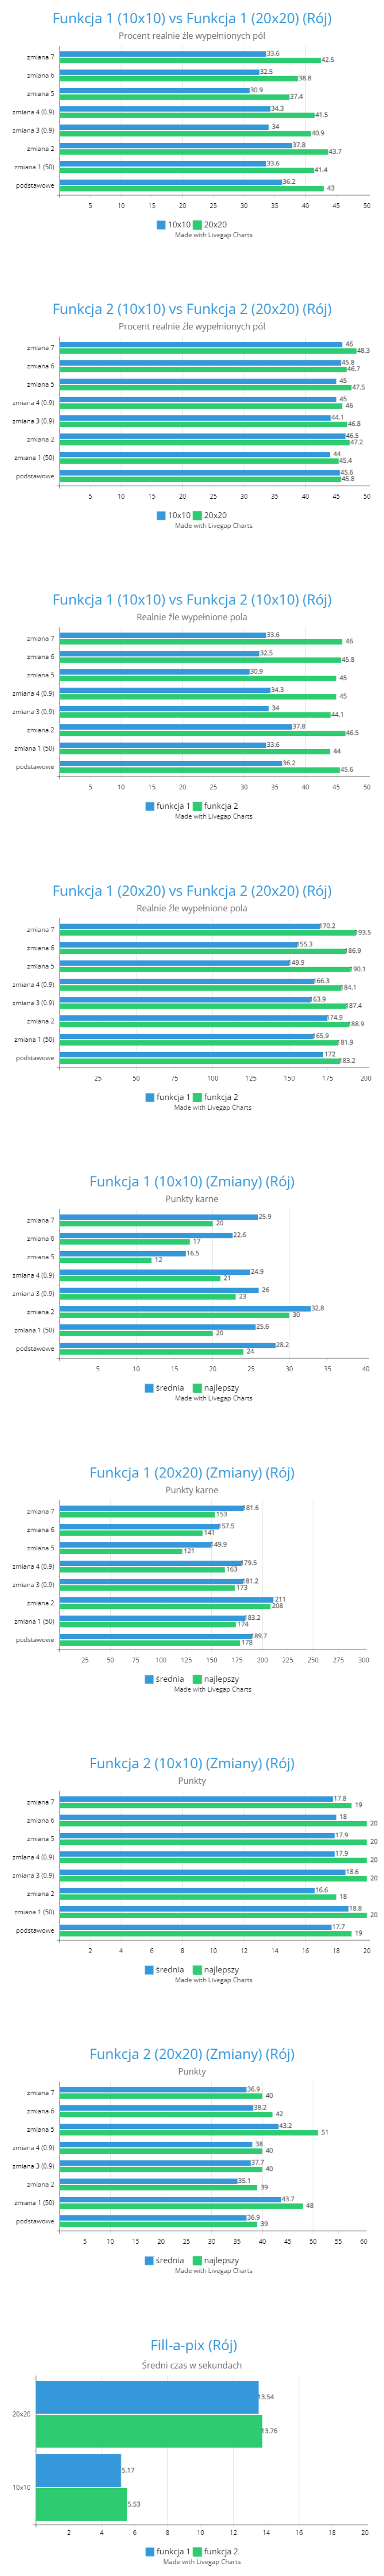

In [21]:
# pobierania obrazków
roj1 = mpimg.imread('./Funkcja 1 (10x10) vs Funkcja 1 (20x20) (Rój).png')
roj2 = mpimg.imread('./Funkcja 2 (10x10) vs Funkcja 2 (20x20) (Rój).PNG')

roj3 = mpimg.imread('./Funkcja 1 (10x10) vs Funkcja 2 (10x10) (Rój).PNG')
roj4 = mpimg.imread('./Funkcja 1 (20x20) vs Funkcja 2 (20x20) (Rój).PNG')

roj5 = mpimg.imread('./Funkcja 1 (10x10) (Zmiany) (Rój).png')
roj6 = mpimg.imread('./Funkcja 1 (20x20) (zmiany) (Rój).PNG')

roj7 = mpimg.imread('./Funkcja 2 (10x10) (zmiany) (Rój).PNG')
roj8 = mpimg.imread('./Funkcja 2 (20x20) (zmiany) (Rój).PNG')

roj9 = mpimg.imread('./Fill-a-pix times (Rój).PNG')

# tworzymy pojemnik, w którym będą obrazki
fig = plt.figure(figsize=(20, 100))

# 3 obrazki w 1 rzędzie
rows = 9
columns = 1

fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(roj1)
plt.axis('off')

fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(roj2)
plt.axis('off')

fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(roj3)
plt.axis('off')

fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(roj4)
plt.axis('off')

fig.add_subplot(rows, columns, 5)

# showing image
plt.imshow(roj5)
plt.axis('off')

fig.add_subplot(rows, columns, 6)

# showing image
plt.imshow(roj6)
plt.axis('off')

fig.add_subplot(rows, columns, 7)

# showing image
plt.imshow(roj7)
plt.axis('off')

fig.add_subplot(rows, columns, 8)

# showing image
plt.imshow(roj8)
plt.axis('off')

fig.add_subplot(rows, columns, 9)

# showing image
plt.imshow(roj9)
plt.axis('off')

#### Przy porównywaniu czasów użyte ustawienia to:
* ps.single.GlobalBestPSO (topologia = star)
* options = {'c1': 0.5, 'c2': 0.3, 'w':0.9, 'k':2, 'p':1}
* n_particles = 10
* dimensions = 100
* iters = 1000

### Porównanie Algorytmu genetycznego i Roju na podstawie powyższych testów

(-0.5, 699.5, 449.5, -0.5)

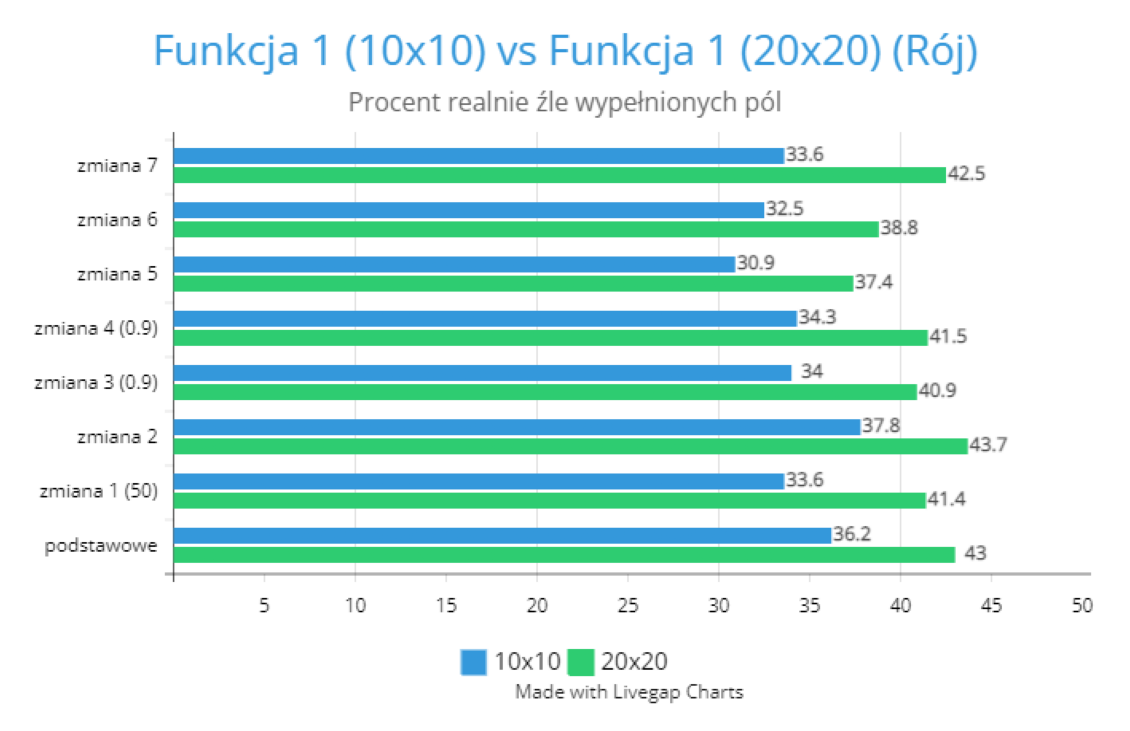

In [23]:
roj_vs_ag = mpimg.imread('./Fill-a-pix (Rój vs Algorytm genetyczny).png')

# tworzymy pojemnik, w którym będą obrazki
fig = plt.figure(figsize=(20, 20))

# 3 obrazki w 1 rzędzie
rows = 1
columns = 1

fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(roj1)
plt.axis('off')

---
Algorytm genetyczne ma lepsze wyniki więc z nim spróbujemy, znaleść lepsze rozwiązanie.
Testy będziemy robić na 10x10.

### Blok, w którym ustawiamy naszą funkcje fitness (fill-a-pix 10x10) (funkcja 3)

In [38]:
def fitness_func_final(solution, solution_idx):
    # solution jest wypełniony zerami i jedynkami
    # zero = białe pole, jedynka = czarne pole

    # liczymy punkty karne
    penalty_points = 0

    # długość jednego rzędu
    length = int(sqrt(len(solution)))

    # najpierw zmieniamy listę długości 100 na listę 10x10
    solution_10_x_10 = change_to_list_of_lists(solution, length)

    for i1 in range(length):
        for i2 in range(length):
            if fill_a_pix_10_x_10[i1][i2] != -1:
                # sprawdzamy ile jest czarnych pól
                # przy sumowanie wystarczy sumować wartości pól, bo czarne pole to 1, a białe to 0

                # odpowiednia liczba czarnych kratek to wartość pola obrazka w formie tablicy tablic
                correct_number_of_black_blocks = fill_a_pix_10_x_10[i1][i2]
                # na starcie do sumy dodajemy wartość pola, które analizujemy i ilość czarnych pól dookoła
                number_of_black_blocks = solution_10_x_10[i1][i2] + get_number_of_black_pixels_around_this_pixel(i1, i2, solution_10_x_10, length)

                # ----------------------------------------------------------------------------1
                # o ile od prawidłowej liczby czarnych kratek różniła się uzyskana liczba,
                # jeżeli nie ma różnicy to dostajemy punkty
                if correct_number_of_black_blocks == number_of_black_blocks:
                    penalty_points += 2
                else:
                    penalty_points -= abs(correct_number_of_black_blocks - number_of_black_blocks)
                # ----------------------------------------------------------------------------2


    # zwracamy punkty karne
    return penalty_points

### Blok gdzie konfigurujemy algorytm. (fill-a-pix 10x10) (funkcja 3)

In [41]:
# zakres wartość pojawiających się w solution tylko zera i jedynki
gene_space = [0, 1]

# funkcja fitness
fitness_function = fitness_func_final

# ile chromosomów w populacji
sol_per_pop = 500 #30 try 500

# ile genów ma chromosom
num_genes = 100 #100

# ile wyłaniamy rodziców do "rozmnażania"
num_parents_mating = 50 #8 try 50

# ile pokoleń
num_generations = 190 # 190 # try 5000

# ilu rodziców zachować (kilka procent)
keep_parents = 4 # 4

# jaki typ selekcji rodziców?
# sss = steady, rws=roulette, rank = rankingowa, tournament = turniejowa
parent_selection_type = "sss"

# w ilu punktach robić krzyżowanie?
# "single_point" = skrzyżowanie robimy w jednym punkcie
crossover_type = "two_points" # two_points

# na ilu procent genów ma działać mutacja?
mutation_percent_genes = 1 # 1

# typ mutacji
mutation_type = "random"

### uruchomienie algorytmu. (fill-a-pix 10x10) (funkcja 3)

In [42]:
# czyścimy z poprzednich obrazków do animacji
fill_a_pix_10_x_10_images = []
# do liczenia średniej czasu
average_time = 0
# zbieramy sumę do liczenia średniej punktów karnych
results = 0
# zbieramy sumę do liczenia średniej realnej ilości źle wypełnionych kratek
real_result = 0
# do testów można wybrać ile razy uruchomimy algorytm
for a in range(10):
    # zaczynamy liczyć czas
    start = time.time()
    # ustawienie algorytmu
    ga_instance = pygad.GA(gene_space=gene_space,
                           num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_function,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes,
                           parent_selection_type=parent_selection_type,
                           keep_parents=keep_parents,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_percent_genes,
                           )

    # uruchomienie algorytmu
    ga_instance.run()

    # podsumowanie: najlepsze znalezione rozwiązanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
    # wyświetlenie wykresu: jak się zmieniała wartość punktów karnych na kolejnych etapach
    # ga_instance.plot_fitness()

    # liczymy ile czasu działał algorytm i dodajemy, by policzyć średnią
    end = time.time()
    average_time += (end - start)

    # do zrobienia obrazka i policzenia realnie źle wypełnionych kratek potrzebujemy listę list 10x10
    solution_10_x_10 = change_to_list_of_lists(solution, 10)
    # # zrobienie obrazka z finalnego rozwiązania
    # mask = np.array(solution_10_x_10, dtype=bool)
    # # wyświetlenie tego obrazka
    # plt.imshow(mask, cmap='gray')
    # plt.show()

    number_of_wrong_pixels = 0
    # policzenie realnej ilość blednie uzupełnionych pexeli porównując z rozwiązaniem
    for i1 in range (10):
        for i2 in range (10):
            if fill_a_pix_10_x_10_solution[i1][i2] != solution_10_x_10[i1][i2]:
                number_of_wrong_pixels += 1

    real_result += number_of_wrong_pixels
    results += solution_fitness

    print("Real number of wrong pixels = {number_of_wrong_pixels}".format(number_of_wrong_pixels=number_of_wrong_pixels))

print("średnia karnych punktów: ", results/10)
print("średnia realnie źle wypełnionych bloczków: ", real_result/10)
print("średni czas: ", average_time/10)

Fitness value of the best solution = 60
Real number of wrong pixels = 37
Fitness value of the best solution = 61
Real number of wrong pixels = 15
Fitness value of the best solution = 68
Real number of wrong pixels = 16
Fitness value of the best solution = 68
Real number of wrong pixels = 18
Fitness value of the best solution = 62
Real number of wrong pixels = 16
Fitness value of the best solution = 67
Real number of wrong pixels = 16
Fitness value of the best solution = 67
Real number of wrong pixels = 22
Fitness value of the best solution = 62
Real number of wrong pixels = 23
Fitness value of the best solution = 55
Real number of wrong pixels = 29
Fitness value of the best solution = 68
Real number of wrong pixels = 16
średnia karnych punktów:  63.8
średnia realnie źle wypełnionych bloczków:  20.8
średni czas:  17.313811206817626


##### Testy robione na 10 próbach.
##### Ustawienia:
* sol_per_pop = 30
* num_genes = 100
* num_parents_mating = 8
* num_generations = 190
* keep_parents = 4
* parent_selection_type = "sss"
* crossover_type = "single_point"
* mutation_percent_genes = 1
* mutation_type = "random"

średnia karnych punktów: 58.2
średnia realnie źle wypełnionych bloczków: 21.1
średni czas: 0.95

#### Zmiana 1
num_generations = 5000

średnia karnych punktów: 62.2
średnia realnie źle wypełnionych bloczków: 19.7
średni czas: 23.83

Tylko lekka poprawa.

#### Zmiana 2
sol_per_pop = 500
num_parents_mating = 50

średnia karnych punktów: 63.8
średnia realnie źle wypełnionych bloczków: 20.8
średni czas: 17.31

Ponownie tylko lekka poprawa.

**links**:
1. Jak zrobić animacje z obrazków w pythonie:
https://matplotlib.org/3.5.0/gallery/animation/dynamic_image.html